<a href="https://colab.research.google.com/github/h-marshall69/jaccardSimilarity/blob/main/jaccard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALACIÓN DE DEPENDENCIAS

In [37]:
!pip install nltk seaborn plotly wordcloud networkx node2vec gensim transformers torch torchvision umap-learn textstat langdetect spacy

# 2. IMPORTACIÓN DE LIBRERÍAS

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# NLP y Machine Learning
import spacy
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import umap.umap_ as umap

# Visualización y redes
import networkx as nx
from wordcloud import WordCloud
from collections import Counter
import re
from textstat import flesch_reading_ease
from langdetect import detect

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

import spacy.cli

# Download the Spanish language model
spacy.cli.download("es_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 3. CLASE PRINCIPAL PARA ANÁLISIS INTELIGENTE

In [39]:
class IntelligentNLPAnalyzer:
    def __init__(self):
        self.data = None
        self.processed_data = None
        self.embeddings = None
        self.clusters = None
        self.nlp = spacy.load('es_core_news_sm')
        self.bert_model = None
        self.bert_tokenizer = None
        self.column_types = {}
        self.insights = {}

    def load_data(self, file_path, delimiter=';'):
        """Carga y analiza automáticamente la estructura del dataset"""
        print("🔍 Analizando estructura del dataset...")

        # Cargar datos
        self.data = pd.read_csv(file_path, delimiter=delimiter, encoding='latin-1')

        # Análisis automático de columnas
        self._infer_column_structure()
        self._analyze_data_quality()

        return self.data

    def _infer_column_structure(self):
        """Infiere automáticamente el tipo y propósito de cada columna"""
        print("🧠 Infiriendo estructura de columnas...")

        for col in self.data.columns:
            col_data = self.data[col].dropna()
            if len(col_data) == 0:
                self.column_types[col] = 'empty'
                continue

            # Análisis de patrones
            unique_ratio = len(col_data.unique()) / len(col_data)
            avg_length = col_data.astype(str).str.len().mean()

            # Detectar tipos de columna
            if col_data.dtype in ['int64', 'float64']:
                self.column_types[col] = 'numeric'
            elif unique_ratio < 0.1 and avg_length < 20:
                self.column_types[col] = 'categorical'
            elif avg_length > 50:
                self.column_types[col] = 'text_long'
            elif unique_ratio > 0.8:
                self.column_types[col] = 'identifier'
            else:
                self.column_types[col] = 'text_short'

        # Identificar columna objetivo (última columna con valores A/T)
        last_col = self.data.columns[-1]
        if set(self.data[last_col].dropna().unique()) <= {'A', 'T'}:
            self.column_types[last_col] = 'target'

        print(f"📊 Estructura inferida: {self.column_types}")

    def _analyze_data_quality(self):
        """Analiza la calidad de los datos"""
        print("🔎 Analizando calidad de datos...")

        quality_report = {
            'total_rows': len(self.data),
            'total_columns': len(self.data.columns),
            'missing_values': self.data.isnull().sum().to_dict(),
            'duplicate_rows': self.data.duplicated().sum(),
            'data_types': self.data.dtypes.to_dict()
        }

        self.insights['data_quality'] = quality_report

        # Crear visualización de calidad
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('📊 Análisis de Calidad de Datos', fontsize=16, fontweight='bold')

        # Missing values
        missing_data = pd.Series(quality_report['missing_values'])
        if missing_data[missing_data > 0].sum() > 0: # Check if there are any columns with missing values
            missing_data[missing_data > 0].plot(kind='bar', ax=axes[0,0])
            axes[0,0].set_title('Valores Faltantes por Columna')
            axes[0,0].tick_params(axis='x', rotation=45)
        else:
            axes[0,0].set_title('No hay Valores Faltantes') # Set a title indicating no missing values
            axes[0,0].axis('off') # Turn off axis if no missing values to plot


        # Distribución de tipos de columna
        type_counts = pd.Series(self.column_types).value_counts()
        axes[0,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Distribución de Tipos de Columna')

        # Estadísticas generales
        stats_text = f"""
        Filas Totales: {quality_report['total_rows']:,}
        Columnas Totales: {quality_report['total_columns']}
        Filas Duplicadas: {quality_report['duplicate_rows']}
        Completitud: {((1 - self.data.isnull().sum().sum() / (len(self.data) * len(self.data.columns))) * 100):.1f}%
        """
        axes[1,0].text(0.1, 0.5, stats_text, transform=axes[1,0].transAxes,
                      fontsize=12, verticalalignment='center')
        axes[1,0].set_title('Estadísticas Generales')
        axes[1,0].axis('off')

        # Heatmap de valores faltantes
        missing_matrix = self.data.isnull()
        sns.heatmap(missing_matrix, ax=axes[1,1], cbar=True, yticklabels=False)
        axes[1,1].set_title('Patrón de Valores Faltantes')

        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocesamiento inteligente de datos"""
        print("🔧 Iniciando preprocesamiento inteligente...")

        self.processed_data = self.data.copy()

        # Limpiar y normalizar por tipo de columna
        for col, col_type in self.column_types.items():
            if col_type == 'text_short' or col_type == 'text_long':
                self.processed_data[col] = self._clean_text_column(self.processed_data[col])
            elif col_type == 'categorical':
                self.processed_data[col] = self._clean_categorical_column(self.processed_data[col])

        # Crear columna de texto combinado para análisis NLP
        text_columns = [col for col, type_ in self.column_types.items()
                       if type_ in ['text_short', 'text_long', 'categorical']]

        if text_columns:
            self.processed_data['combined_text'] = self.processed_data[text_columns].fillna('').agg(' '.join, axis=1)
            self.processed_data['combined_text'] = self.processed_data['combined_text'].apply(self._clean_text)

        print(f"✅ Preprocesamiento completado. Shape: {self.processed_data.shape}")
        return self.processed_data

    def _clean_text_column(self, series):
        """Limpia una columna de texto"""
        return series.fillna('').astype(str).str.strip().str.lower()

    def _clean_categorical_column(self, series):
        """Limpia una columna categórica"""
        return series.fillna('desconocido').astype(str).str.strip().str.lower()

    def _clean_text(self, text):
        """Limpia texto individual"""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def generate_embeddings(self, method='bert'):
        """Genera embeddings usando BERT en español"""
        print(f"🤖 Generando embeddings usando {method.upper()}...")

        if 'combined_text' not in self.processed_data.columns:
            raise ValueError("Debe ejecutar preprocess_data() primero")

        texts = self.processed_data['combined_text'].tolist()

        if method == 'bert':
            # Cargar modelo BERT en español
            model_name = "dccuchile/bert-base-spanish-wwm-uncased"
            self.bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.bert_model = AutoModel.from_pretrained(model_name)

            embeddings = []
            batch_size = 32

            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                inputs = self.bert_tokenizer(batch_texts, return_tensors='pt',
                                           padding=True, truncation=True, max_length=512)

                with torch.no_grad():
                    outputs = self.bert_model(**inputs)
                    # Usar el embedding del token [CLS]
                    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
                    embeddings.extend(batch_embeddings)

                if (i // batch_size + 1) % 10 == 0:
                    print(f"   Procesado: {min(i + batch_size, len(texts))}/{len(texts)} textos")

            self.embeddings = np.array(embeddings)

        elif method == 'tfidf':
            vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
            self.embeddings = vectorizer.fit_transform(texts).toarray()

        print(f"✅ Embeddings generados. Shape: {self.embeddings.shape}")
        return self.embeddings

    def perform_clustering(self, n_clusters=None):
        """Realiza clustering no supervisado"""
        print("🎯 Realizando clustering no supervisado...")

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Si no se especifica número de clusters, usar método del codo
        if n_clusters is None:
            n_clusters = self._find_optimal_clusters()

        # Aplicar múltiples algoritmos de clustering
        clustering_results = {}

        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clustering_results['kmeans'] = kmeans.fit_predict(self.embeddings)

        # DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        clustering_results['dbscan'] = dbscan.fit_predict(self.embeddings)

        # Clustering Jerárquico
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        clustering_results['hierarchical'] = hierarchical.fit_predict(self.embeddings)

        # Agregar clusters al dataframe
        for method, labels in clustering_results.items():
            self.processed_data[f'cluster_{method}'] = labels

        self.clusters = clustering_results
        print(f"✅ Clustering completado con {n_clusters} clusters")

        # Visualizar resultados de clustering
        self._visualize_clustering()

        return clustering_results

    def _find_optimal_clusters(self):
        """Encuentra el número óptimo de clusters usando método del codo"""
        inertias = []
        k_range = range(2, min(11, len(self.embeddings) // 10))

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(self.embeddings)
            inertias.append(kmeans.inertia_)

        # Calcular segunda derivada para encontrar el codo
        if len(inertias) > 2:
            second_derivatives = np.diff(inertias, n=2)
            optimal_k = k_range[np.argmax(second_derivatives) + 1]
        else:
            optimal_k = k_range[0]

        print(f"📊 Número óptimo de clusters estimado: {optimal_k}")
        return optimal_k

    def _visualize_clustering(self):
        """Visualiza los resultados de clustering"""
        # Adjust perplexity based on the number of samples
        perplexity_value = min(30, len(self.embeddings) - 1)
        if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1


        if self.embeddings.shape[1] > 2:
            # Reducir dimensionalidad para visualización
            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
            embeddings_2d = tsne.fit_transform(self.embeddings)

            umap_reducer = umap.UMAP(n_components=2, random_state=42)
            embeddings_umap = umap_reducer.fit_transform(self.embeddings)
        else:
            embeddings_2d = self.embeddings
            embeddings_umap = self.embeddings

        # Crear subplots para diferentes métodos
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=['K-Means (t-SNE)', 'DBSCAN (t-SNE)', 'Hierarchical (t-SNE)',
                          'K-Means (UMAP)', 'DBSCAN (UMAP)', 'Hierarchical (UMAP)'],
            specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}],
                   [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]]
        )

        methods = ['kmeans', 'dbscan', 'hierarchical']
        embeddings_list = [embeddings_2d, embeddings_2d, embeddings_2d,
                          embeddings_umap, embeddings_umap, embeddings_umap]

        for i, method in enumerate(methods):
            if method in self.clusters:
                # t-SNE plots
                fig.add_trace(
                    go.Scatter(
                        x=embeddings_2d[:, 0],
                        y=embeddings_2d[:, 1],
                        mode='markers',
                        marker=dict(color=self.clusters[method], size=6, colorscale='viridis'),
                        name=f'{method.upper()}',
                        showlegend=False
                    ),
                    row=1, col=i+1
                )

                # UMAP plots
                fig.add_trace(
                    go.Scatter(
                        x=embeddings_umap[:, 0],
                        y=embeddings_umap[:, 1],
                        mode='markers',
                        marker=dict(color=self.clusters[method], size=6, colorscale='viridis'),
                        name=f'{method.upper()} UMAP',
                        showlegend=False
                    ),
                    row=2, col=i+1
                )

        fig.update_layout(height=800, title_text="🎯 Resultados de Clustering")
        fig.show()

    def topic_modeling(self, n_topics=5):
        """Realiza modelado de temas usando LDA"""
        print(f"📚 Realizando modelado de temas con {n_topics} tópicos...")

        # Preparar textos para LDA
        texts = self.processed_data['combined_text'].tolist()

        # Vectorización con filtros específicos para español
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000,
                                    stop_words=self._get_spanish_stopwords(),
                                    ngram_range=(1,2))
        doc_term_matrix = vectorizer.fit_transform(texts)

        # Aplicar LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(doc_term_matrix)

        # Extraer temas
        feature_names = vectorizer.get_feature_names_out()
        topics = {}

        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-10:]]
            topics[f'Tema_{topic_idx+1}'] = top_words

        # Asignar tema dominante a cada documento
        doc_topic_probs = lda.transform(doc_term_matrix)
        dominant_topics = doc_topic_probs.argmax(axis=1)
        self.processed_data['dominant_topic'] = dominant_topics

        self.insights['topics'] = topics

        # Visualizar temas
        self._visualize_topics(topics, doc_topic_probs)

        print("✅ Modelado de temas completado")
        return topics

    def _get_spanish_stopwords(self):
        """Retorna lista de stopwords en español"""
        spanish_stops = [
            'el', 'la', 'de', 'que', 'y', 'a', 'en', 'un', 'es', 'se', 'no', 'te', 'lo', 'le',
            'da', 'su', 'por', 'son', 'con', 'para', 'al', 'del', 'los', 'las', 'una', 'sobre',
            'todo', 'también', 'tras', 'otro', 'algún', 'poco', 'esta', 'estas', 'este', 'estos',
            'tan', 'entre', 'durante', 'desde', 'sin', 'bajo', 'hasta', 'según', 'muy', 'más'
        ]
        return spanish_stops

    def _visualize_topics(self, topics, doc_topic_probs):
        """Visualiza los temas encontrados"""
        # WordCloud para cada tema
        n_topics = len(topics)
        fig, axes = plt.subplots(2, (n_topics + 1) // 2, figsize=(15, 8))
        axes = axes.ravel()

        for i, (topic_name, words) in enumerate(topics.items()):
            wordcloud = WordCloud(width=300, height=200, background_color='white').generate(' '.join(words))
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{topic_name}')
            axes[i].axis('off')

        # Ocultar ejes sobrantes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.suptitle('☁️ Word Clouds por Tema', y=1.02, fontsize=16)
        plt.show()

        # Distribución de temas
        topic_distribution = pd.Series(self.processed_data['dominant_topic']).value_counts().sort_index()

        fig = go.Figure(data=[
            go.Bar(x=[f'Tema {i+1}' for i in topic_distribution.index],
                   y=topic_distribution.values)
        ])
        fig.update_layout(title='📊 Distribución de Documentos por Tema')
        fig.show()

    def similarity_analysis(self):
        """Análisis de similitud semántica"""
        print("🔍 Realizando análisis de similitud semántica...")

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Calcular matriz de similitud coseno
        similarity_matrix = cosine_similarity(self.embeddings)

        # Visualizar matriz de similitud
        plt.figure(figsize=(12, 10))
        sns.heatmap(similarity_matrix[:50, :50], cmap='coolwarm', center=0,
                   square=True, fmt='.2f')
        plt.title('🔥 Matriz de Similitud Semántica (primeras 50 muestras)')
        plt.show()

        # Encontrar pares más similares
        np.fill_diagonal(similarity_matrix, -1)  # Excluir auto-similitud
        most_similar_pairs = []

        for i in range(len(similarity_matrix)):
            max_sim_idx = np.argmax(similarity_matrix[i])
            if similarity_matrix[i, max_sim_idx] > 0.8:  # Threshold alto
                most_similar_pairs.append((i, max_sim_idx, similarity_matrix[i, max_sim_idx]))

        self.insights['similarity'] = {
            'matrix': similarity_matrix,
            'similar_pairs': most_similar_pairs
        }

        print(f"✅ Análisis completado. Encontrados {len(most_similar_pairs)} pares altamente similares")
        return similarity_matrix

    def build_semantic_network(self, threshold=0.7):
        """Construye red semántica basada en similitud"""
        print(f"🕸️ Construyendo red semántica con threshold {threshold}...")

        if 'similarity' not in self.insights:
            self.similarity_analysis()

        similarity_matrix = self.insights['similarity']['matrix']

        # Crear grafo
        G = nx.Graph()

        # Agregar nodos
        for i in range(len(similarity_matrix)):
            G.add_node(i)

        # Agregar aristas basadas en similitud
        for i in range(len(similarity_matrix)):
            for j in range(i+1, len(similarity_matrix)):
                if similarity_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=similarity_matrix[i, j])

        # Visualizar red
        plt.figure(figsize=(15, 12))
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Dibujar nodos y aristas
        nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue', alpha=0.7)
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

        plt.title('🕸️ Red Semántica basada en Similitud')
        plt.axis('off')
        plt.show()

        # Análisis de la red
        network_stats = {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'components': nx.number_connected_components(G)
        }

        print(f"📊 Estadísticas de la red: {network_stats}")
        return G

    def predictive_modeling(self):
        """Construye modelo predictivo para la etiqueta objetivo"""
        print("🎯 Construyendo modelos predictivos...")

        # Identificar columna objetivo
        target_column = None
        for col, col_type in self.column_types.items():
            if col_type == 'target':
                target_column = col
                break

        if target_column is None:
            print("⚠️ No se encontró columna objetivo")
            return None

        # Preparar datos
        X = self.embeddings
        y = self.processed_data[target_column].dropna()

        # Filtrar X para que coincida con y
        valid_indices = self.processed_data[target_column].dropna().index
        X = X[valid_indices]

        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

        # Entrenar múltiples modelos
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }

        results = {}

        for name, model in models.items():
            print(f"   Entrenando {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            results[name] = {
                'model': model,
                'predictions': y_pred,
                'report': classification_report(y_test, y_pred, output_dict=True)
            }

        # Visualizar resultados
        self._visualize_model_results(results, y_test, le)

        self.insights['predictive_models'] = results
        print("✅ Modelado predictivo completado")
        return results

    def _visualize_model_results(self, results, y_test, label_encoder):
        """Visualiza resultados de modelos predictivos"""
        fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
        if len(results) == 1:
            axes = [axes]

        for i, (model_name, result) in enumerate(results.items()):
            y_pred = result['predictions']
            cm = confusion_matrix(y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
            axes[i].set_title(f'{model_name}\nAccuracy: {result["report"]["accuracy"]:.3f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

            # Etiquetas
            labels = label_encoder.classes_
            axes[i].set_xticklabels(labels)
            axes[i].set_yticklabels(labels)

        plt.tight_layout()
        plt.suptitle('🎯 Matrices de Confusión - Modelos Predictivos', y=1.02)
        plt.show()

    def recommendation_system(self, index=0, top_k=5):
        """Sistema de recomendación basado en similitud"""
        print(f"💡 Generando recomendaciones para muestra {index}...")

        if 'similarity' not in self.insights:
            self.similarity_analysis()

        similarity_matrix = self.insights['similarity']['matrix']

        # Obtener similitudes para el índice dado
        similarities = similarity_matrix[index]

        # Encontrar los más similares (excluyendo el mismo)
        similarities[index] = -1
        top_indices = similarities.argsort()[-top_k:][::-1]

        # Crear DataFrame con recomendaciones
        recommendations = pd.DataFrame({
            'Índice': top_indices,
            'Similitud': similarities[top_indices],
            'Texto': [self.processed_data.iloc[i]['combined_text'][:100] + '...'
                     for i in top_indices]
        })

        print("🔍 Muestra de referencia:")
        print(f"   {self.processed_data.iloc[index]['combined_text'][:100]}...")
        print("\n💡 Recomendaciones:")
        for i, row in recommendations.iterrows():
            print(f"   {i+1}. Similitud: {row['Similitud']:.3f}")
            print(f"      {row['Texto']}")
            print()

        return recommendations

    def generate_comprehensive_report(self):
        """Genera reporte completo del análisis"""
        print("📋 Generando reporte completo...")

        report = {
            'resumen_dataset': {
                'filas': len(self.data),
                'columnas': len(self.data.columns),
                'tipos_columna': self.column_types,
                'completitud': f"{((1 - self.data.isnull().sum().sum() / (len(self.data) * len(self.data.columns))) * 100):.1f}%"
            },
            'insights_principales': {},
            'recomendaciones': []
        }

        # Análisis de clustering
        if self.clusters:
            cluster_info = {}
            for method, labels in self.clusters.items():
                unique_labels = len(set(labels))
                if -1 in labels:  # DBSCAN puede tener noise points
                    unique_labels -= 1
                cluster_info[method] = f"{unique_labels} clusters"
            report['insights_principales']['clustering'] = cluster_info

        # Análisis de temas
        if 'topics' in self.insights:
            report['insights_principales']['temas'] = len(self.insights['topics'])

        # Modelos predictivos
        if 'predictive_models' in self.insights:
            best_model = max(self.insights['predictive_models'].items(),
                           key=lambda x: x[1]['report']['accuracy'])
            report['insights_principales']['mejor_modelo'] = {
                'nombre': best_model[0],
                'accuracy': f"{best_model[1]['report']['accuracy']:.3f}"
            }

        # Generar recomendaciones
        report['recomendaciones'] = [
            "Considerar aumentar el dataset si es posible para mejorar la robustez",
            "Explorar feature engineering adicional basado en los patrones encontrados",
            "Implementar validación cruzada para modelos más robustos",
            "Considerar técnicas de ensemble para mejorar el rendimiento predictivo"
        ]

        # Mostrar reporte
        print("\n" + "="*60)
        print("📊 REPORTE COMPLETO DE ANÁLISIS NLP")
        print("="*60)

        print(f"\n📈 RESUMEN DEL DATASET:")
        print(f"   • Filas: {report['resumen_dataset']['filas']:,}")
        print(f"   • Columnas: {report['resumen_dataset']['columnas']}")
        print(f"   • Completitud: {report['resumen_dataset']['completitud']}")

        print(f"\n🧠 INSIGHTS PRINCIPALES:")
        for key, value in report['insights_principales'].items():
            if isinstance(value, dict):
                print(f"   • {key.title()}:")
                for k, v in value.items():
                    print(f"     - {k}: {v}")
            else:
                print(f"   • {key.title()}: {value}")

        print(f"\n💡 RECOMENDACIONES:")
        for i, rec in enumerate(report['recomendaciones'], 1):
            print(f"   {i}. {rec}")

        print("\n" + "="*60)

        return report

    def anomaly_detection(self, contamination=0.1):
        """Detecta anomalías en los datos"""
        print("🚨 Realizando detección de anomalías...")

        from sklearn.ensemble import IsolationForest
        from sklearn.preprocessing import StandardScaler

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Normalizar embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(self.embeddings)

        # Aplicar Isolation Forest
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        anomaly_labels = iso_forest.fit_predict(embeddings_scaled)

        # Añadir etiquetas al dataset
        self.processed_data['is_anomaly'] = anomaly_labels == -1

        # Análisis de anomalías
        n_anomalies = sum(anomaly_labels == -1)
        anomaly_rate = n_anomalies / len(anomaly_labels) * 100

        print(f"🔍 Detectadas {n_anomalies} anomalías ({anomaly_rate:.1f}% del dataset)")

        # Visualizar anomalías
        if self.embeddings.shape[1] > 2:
            # Adjust perplexity based on the number of samples
            perplexity_value = min(30, len(embeddings_scaled) - 1)
            if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1

            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
            embeddings_2d = tsne.fit_transform(embeddings_scaled)
        else:
            embeddings_2d = embeddings_scaled

        plt.figure(figsize=(12, 8))

        # Puntos normales
        normal_mask = anomaly_labels == 1
        plt.scatter(embeddings_2d[normal_mask, 0], embeddings_2d[normal_mask, 1],
                   c='blue', alpha=0.6, label='Normal', s=50)

        # Anomalías
        anomaly_mask = anomaly_labels == -1
        plt.scatter(embeddings_2d[anomaly_mask, 0], embeddings_2d[anomaly_mask, 1],
                   c='red', alpha=0.8, label='Anomalía', s=100, marker='x')

        plt.title('🚨 Detección de Anomalías (t-SNE)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Mostrar ejemplos de anomalías
        anomaly_indices = self.processed_data[self.processed_data['is_anomaly']].index[:5]
        print("\n🔍 Ejemplos de anomalías detectadas:")
        for i, idx in enumerate(anomaly_indices, 1):
            text = self.processed_data.iloc[idx]['combined_text'][:100]
            print(f"   {i}. Índice {idx}: {text}...")

        return anomaly_labels

    def advanced_visualizations(self):
        """Genera visualizaciones avanzadas interactivas"""
        print("📊 Generando visualizaciones avanzadas...")

        # 1. Dashboard interactivo con plotly
        if self.clusters and 'combined_text' in self.processed_data.columns:
            self._create_interactive_dashboard()

        # 2. Análisis temporal si hay patrones temporales
        self._analyze_temporal_patterns()

        # 3. Análisis de correlaciones categóricas
        self._analyze_categorical_correlations()

    def _create_interactive_dashboard(self):
        """Crea dashboard interactivo"""
        # Adjust perplexity based on the number of samples
        perplexity_value = min(30, len(self.embeddings) - 1)
        if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1

        # Reducir dimensionalidad para visualización
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
        embeddings_2d = tsne.fit_transform(self.embeddings)

        # Crear DataFrame para plotly
        viz_data = pd.DataFrame({
            'x': embeddings_2d[:, 0],
            'y': embeddings_2d[:, 1],
            'cluster_kmeans': self.processed_data['cluster_kmeans'],
            'text_preview': [text[:100] + '...' for text in self.processed_data['combined_text']],
            'index': range(len(embeddings_2d))
        })

        # Agregar información adicional si existe
        if 'dominant_topic' in self.processed_data.columns:
            viz_data['topic'] = self.processed_data['dominant_topic']

        # Crear figura interactiva
        fig = px.scatter(
            viz_data,
            x='x', y='y',
            color='cluster_kmeans',
            hover_data=['index', 'text_preview'],
            title='🎯 Visualización Interactiva de Clusters (t-SNE)',
            color_continuous_scale='viridis'
        )

        fig.update_traces(marker=dict(size=8, opacity=0.7))
        fig.update_layout(height=600)
        fig.show()

    def _analyze_temporal_patterns(self):
        """Analiza patrones temporales si existen"""
        # Buscar columnas que podrían ser temporales
        date_patterns = []
        for col in self.data.columns:
            if self.data[col].dtype == 'object':
                sample_values = self.data[col].dropna().astype(str).head(10)
                # Buscar patrones de fecha
                date_like = sum(1 for val in sample_values
                              if re.search(r'\d{2,4}[-/]\d{1,2}[-/]\d{1,4}', str(val)))
                if date_like > 5:  # Al menos 50% parecen fechas
                    date_patterns.append(col)

        if date_patterns:
            print(f"📅 Encontradas posibles columnas temporales: {date_patterns}")
            # Aquí podrías agregar análisis temporal específico
        else:
            print("📅 No se detectaron patrones temporales claros")

    def _analyze_categorical_correlations(self):
        """Analiza correlaciones entre variables categóricas"""
        categorical_cols = [col for col, col_type in self.column_types.items()
                          if col_type == 'categorical']

        if len(categorical_cols) > 1:
            print("🔗 Analizando correlaciones categóricas...")

            # Crear matriz de correlación usando Cramér's V
            from scipy.stats import chi2_contingency

            corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

            for col1 in categorical_cols:
                for col2 in categorical_cols:
                    if col1 == col2:
                        corr_matrix.loc[col1, col2] = 1.0
                    else:
                        # Crear tabla de contingencia
                        contingency = pd.crosstab(self.processed_data[col1],
                                                self.processed_data[col2])

                        # Calcular Cramér's V
                        chi2, _, _, _ = chi2_contingency(contingency)
                        n = contingency.sum().sum()
                        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
                        corr_matrix.loc[col1, col2] = cramers_v

            # Visualizar correlaciones categóricas
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm',
                       center=0, square=True)
            plt.title('🔗 Correlaciones Categóricas (Cramér\'s V)')
            plt.show()

# 4. FUNCIONES DE USO Y EJEMPLO PRÁCTICO

In [40]:
def create_sample_dataset():
    """Crea un dataset de ejemplo para demostración"""
    np.random.seed(42)
    n_samples = 200

    # Simular datos con diferentes características
    data = {
        'col_1': np.random.choice(['alto', 'medio', 'bajo'], n_samples),
        'col_2': np.random.choice(['profesional', 'estudiante', 'jubilado', 'otro'], n_samples),
        'col_3': [f"descripción {i} con características variadas y texto en español"
                  for i in range(n_samples)],
        'col_4': np.random.choice(['A', 'B', 'C'], n_samples),
        'col_5': np.random.choice(['norte', 'sur', 'este', 'oeste'], n_samples),
        'target': np.random.choice(['A', 'T'], n_samples)
    }

    # Introducir algunos valores faltantes
    for col in ['col_1', 'col_2']:
        mask = np.random.random(n_samples) < 0.1
        data[col] = [val if not mask[i] else np.nan for i, val in enumerate(data[col])]

    df = pd.DataFrame(data)
    return df

def run_complete_analysis(file_path=None, delimiter=';'):
    """Ejecuta análisis completo del dataset"""
    print("🚀 INICIANDO ANÁLISIS NLP COMPLETO")
    print("="*50)

    # Inicializar analizador
    analyzer = IntelligentNLPAnalyzer()

    # Cargar datos
    if file_path is None:
        print("📝 Usando dataset de ejemplo...")
        analyzer.data = create_sample_dataset()
        analyzer._infer_column_structure()
        analyzer._analyze_data_quality()
    else:
        analyzer.load_data(file_path, delimiter)

    # Ejecutar pipeline completo
    try:
        # 1. Preprocesamiento
        analyzer.preprocess_data()

        # 2. Generar embeddings
        analyzer.generate_embeddings(method='bert')  # Cambiar a 'tfidf' si BERT falla

        # 3. Clustering
        analyzer.perform_clustering()

        # 4. Modelado de temas
        analyzer.topic_modeling(n_topics=5)

        # 5. Análisis de similitud
        analyzer.similarity_analysis()

        # 6. Red semántica
        analyzer.build_semantic_network(threshold=0.7)

        # 7. Modelado predictivo
        analyzer.predictive_modeling()

        # 8. Sistema de recomendaciones
        analyzer.recommendation_system(index=0, top_k=5)

        # 9. Detección de anomalías
        analyzer.anomaly_detection()

        # 10. Visualizaciones avanzadas
        analyzer.advanced_visualizations()

        # 11. Reporte final
        final_report = analyzer.generate_comprehensive_report()

        print("\n🎉 ¡ANÁLISIS COMPLETADO EXITOSAMENTE!")

        return analyzer, final_report

    except Exception as e:
        print(f"❌ Error durante el análisis: {str(e)}")
        print("💡 Intentando con embeddings TF-IDF como alternativa...")

        try:
            analyzer.generate_embeddings(method='tfidf')
            analyzer.perform_clustering()
            analyzer.topic_modeling(n_topics=3)
            analyzer.similarity_analysis()
            final_report = analyzer.generate_comprehensive_report()

            print("✅ Análisis completado con configuración alternativa")
            return analyzer, final_report

        except Exception as e2:
            print(f"❌ Error crítico: {str(e2)}")
            return None, None

# 5. EJECUCIÓN DEL ANÁLISIS

🚀 INICIANDO ANÁLISIS NLP COMPLETO
🔍 Analizando estructura del dataset...
🧠 Infiriendo estructura de columnas...
📊 Estructura inferida: {'Nombre': 'identifier', 'trabajo': 'categorical', 'Unnamed: 2': 'categorical', 'Unnamed: 3': 'categorical', 'Unnamed: 4': 'categorical', 'Unnamed: 5': 'target'}
🔎 Analizando calidad de datos...


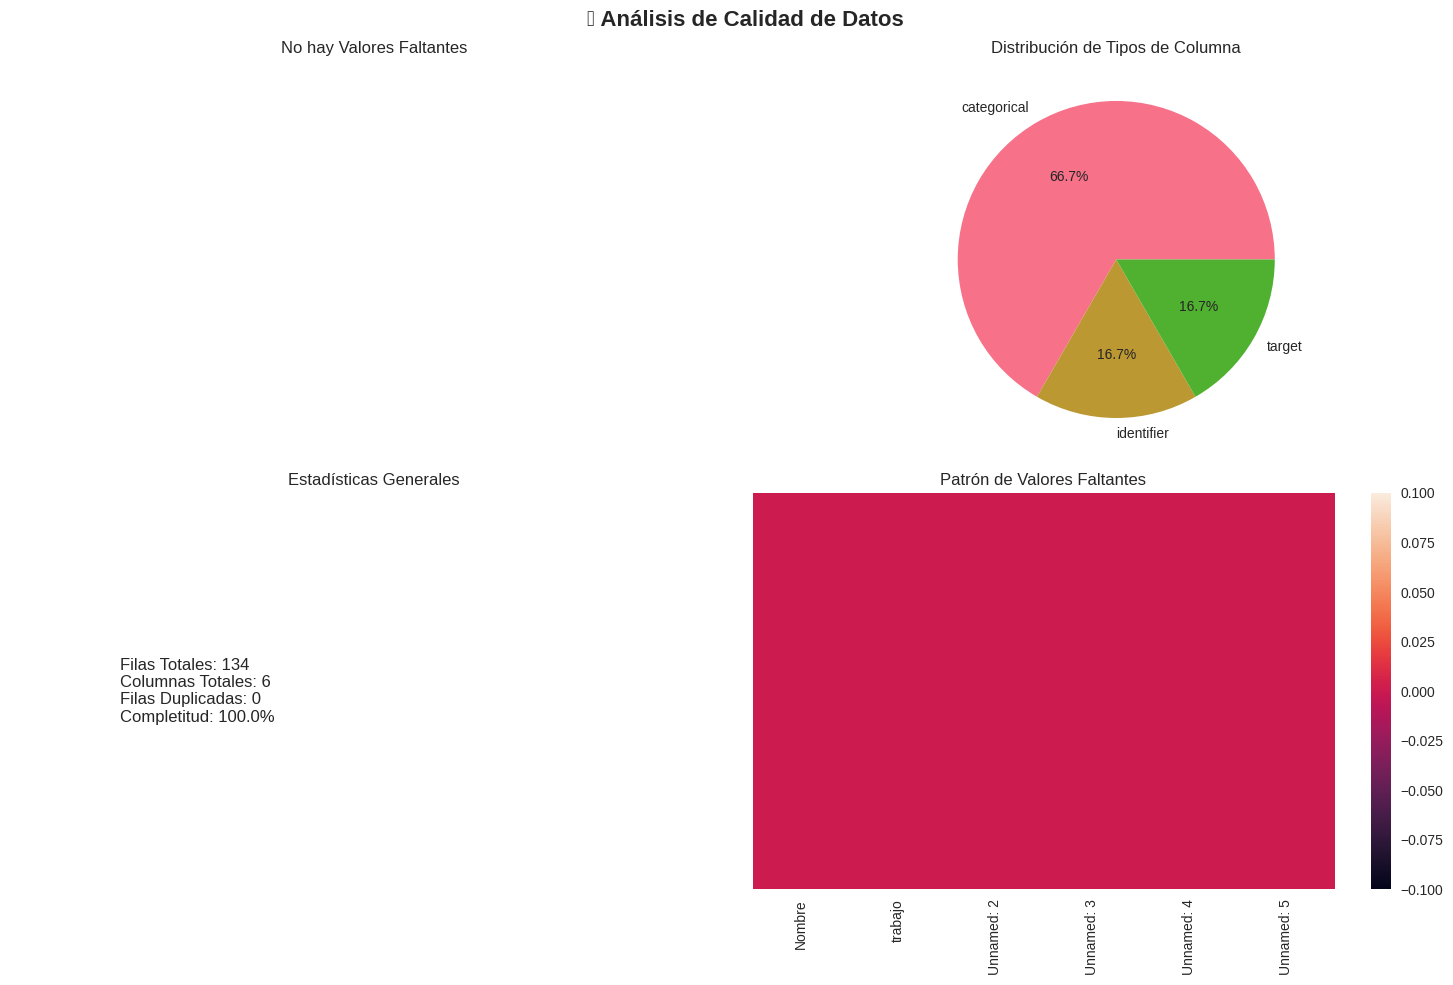

🔧 Iniciando preprocesamiento inteligente...
✅ Preprocesamiento completado. Shape: (134, 7)
🤖 Generando embeddings usando BERT...


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Embeddings generados. Shape: (134, 768)
🎯 Realizando clustering no supervisado...
📊 Número óptimo de clusters estimado: 4
✅ Clustering completado con 4 clusters


📚 Realizando modelado de temas con 5 tópicos...


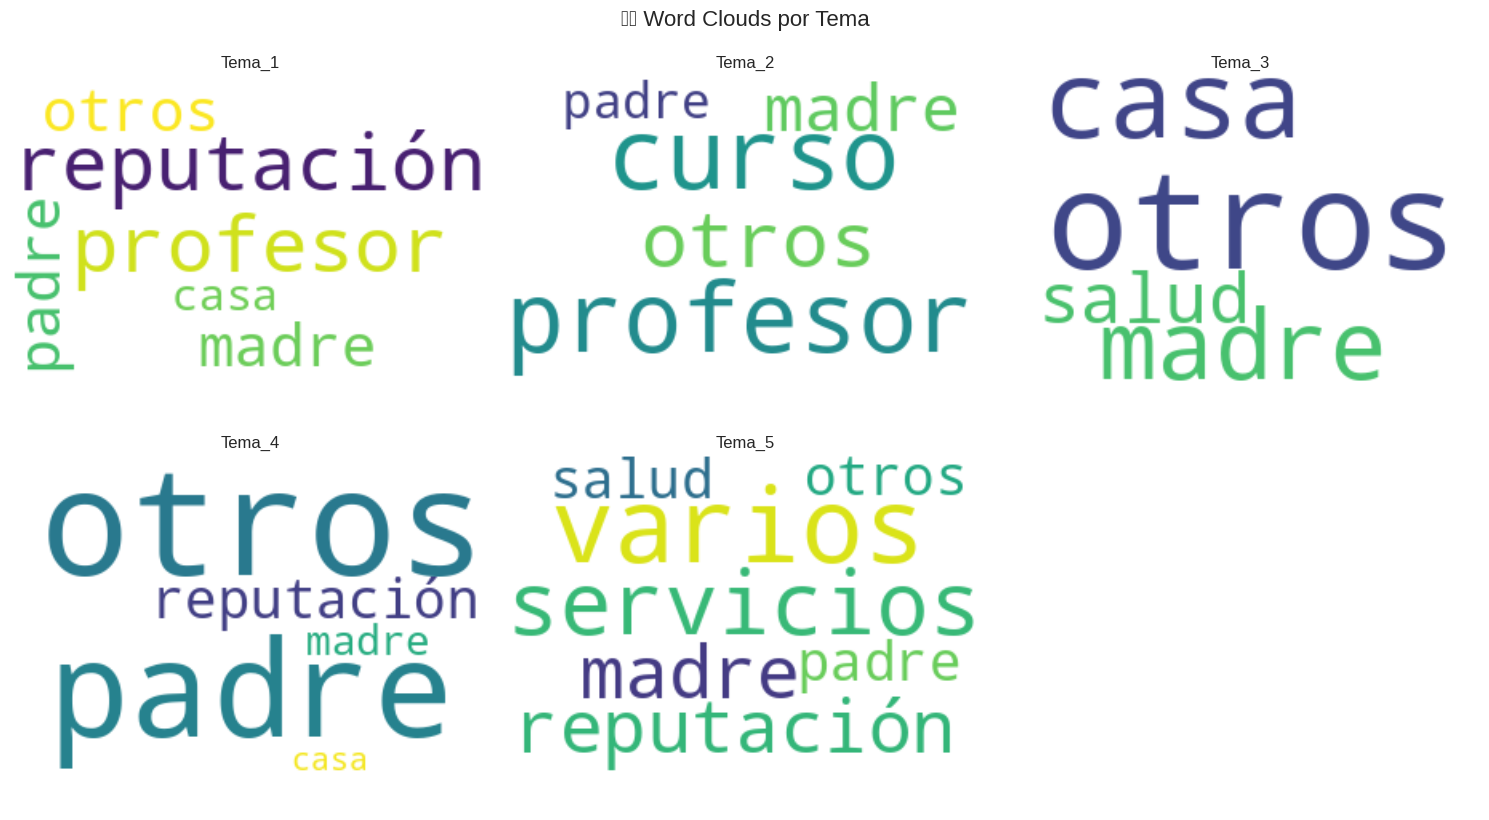

✅ Modelado de temas completado
🔍 Realizando análisis de similitud semántica...


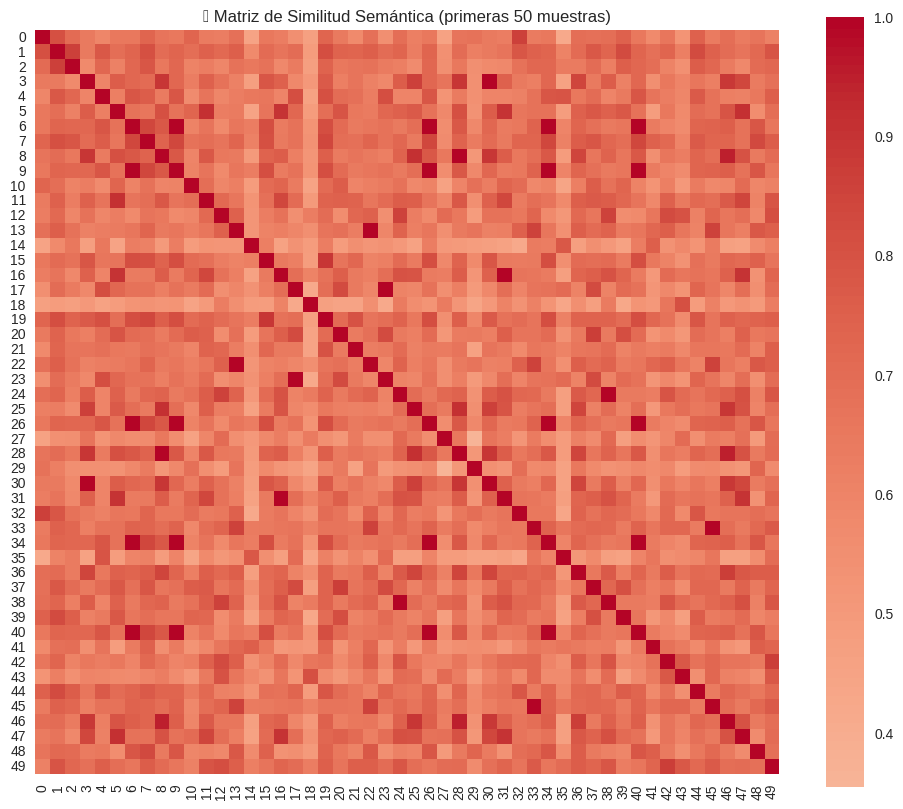

✅ Análisis completado. Encontrados 132 pares altamente similares
🕸️ Construyendo red semántica con threshold 0.7...


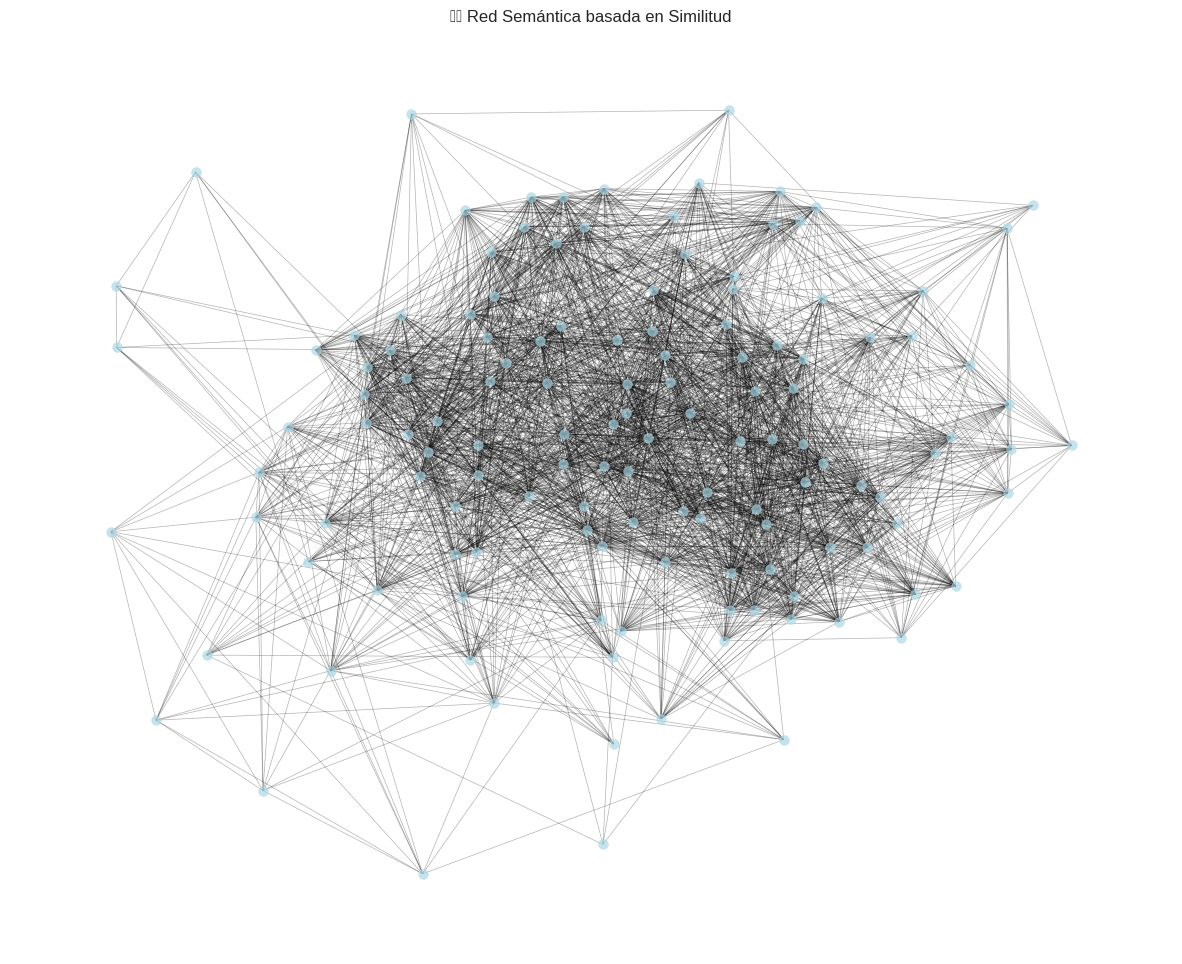

📊 Estadísticas de la red: {'nodes': 134, 'edges': 2753, 'density': 0.3089440017955336, 'components': 1}
🎯 Construyendo modelos predictivos...
   Entrenando Random Forest...
   Entrenando Logistic Regression...


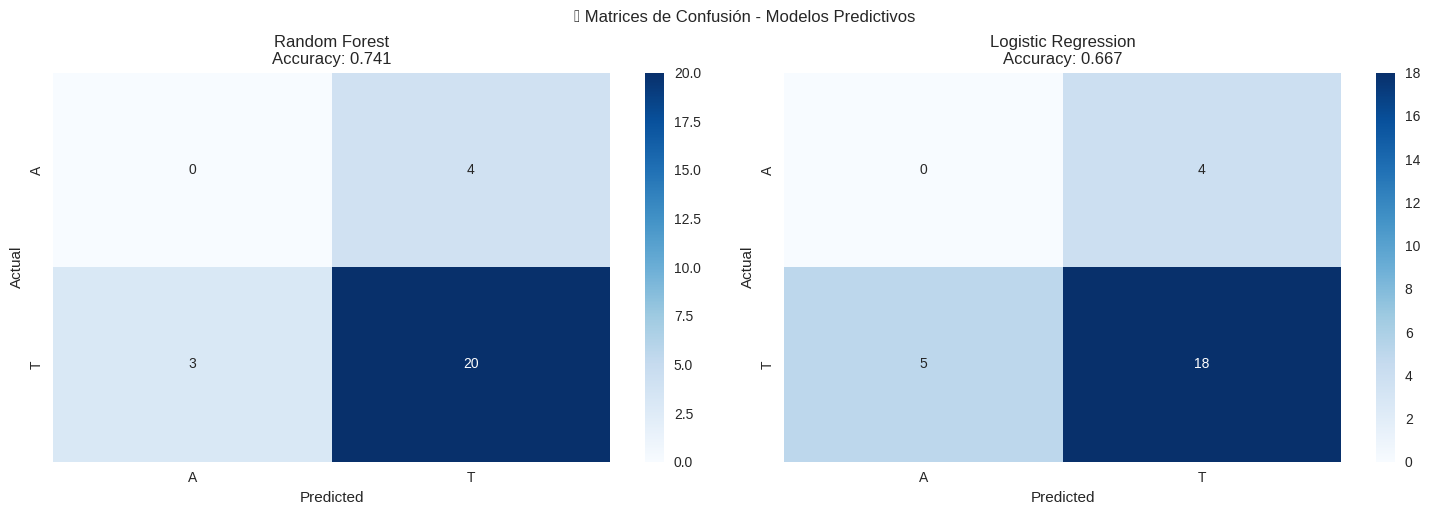

✅ Modelado predictivo completado
💡 Generando recomendaciones para muestra 0...
🔍 Muestra de referencia:
   en casa profesor curso madre...

💡 Recomendaciones:
   1. Similitud: 0.866
      profesor en casa curso madre...

   2. Similitud: 0.814
      en casa servicios varios curso madre...

   3. Similitud: 0.813
      en casa otros curso madre...

   4. Similitud: 0.813
      en casa otros curso madre...

   5. Similitud: 0.813
      en casa otros curso madre...

🚨 Realizando detección de anomalías...
🔍 Detectadas 14 anomalías (10.4% del dataset)


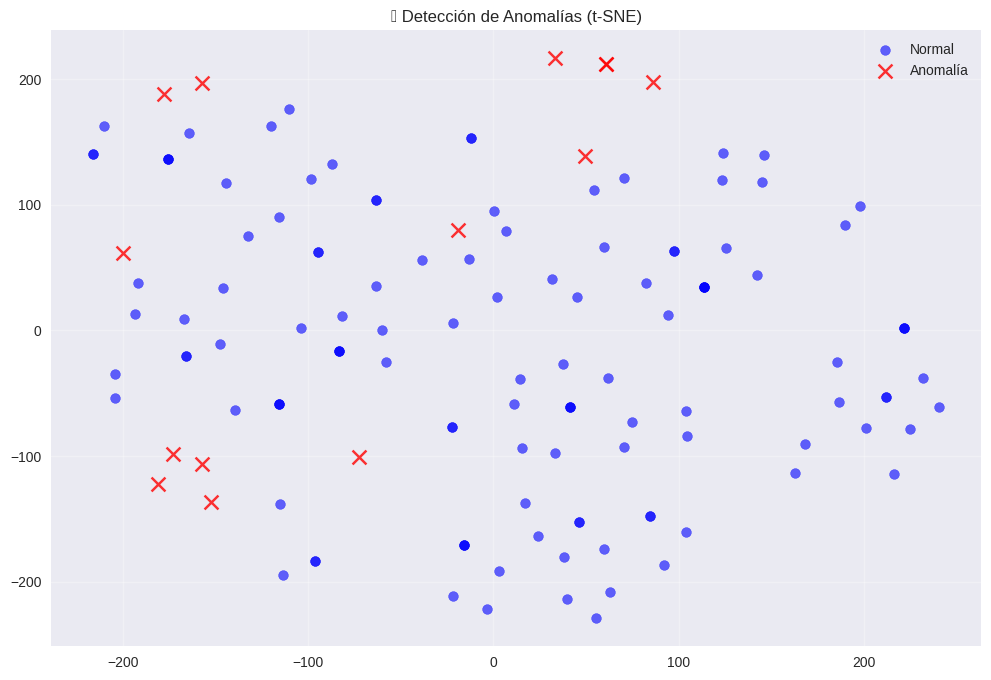


🔍 Ejemplos de anomalías detectadas:
   1. Índice 14: otros otros casa otros...
   2. Índice 27: salud servicios varios otros madre...
   3. Índice 29: profesor profesor casa madre...
   4. Índice 35: otros otros otros padre...
   5. Índice 39: en casa otros reputación madre...
📊 Generando visualizaciones avanzadas...


📅 No se detectaron patrones temporales claros
🔗 Analizando correlaciones categóricas...


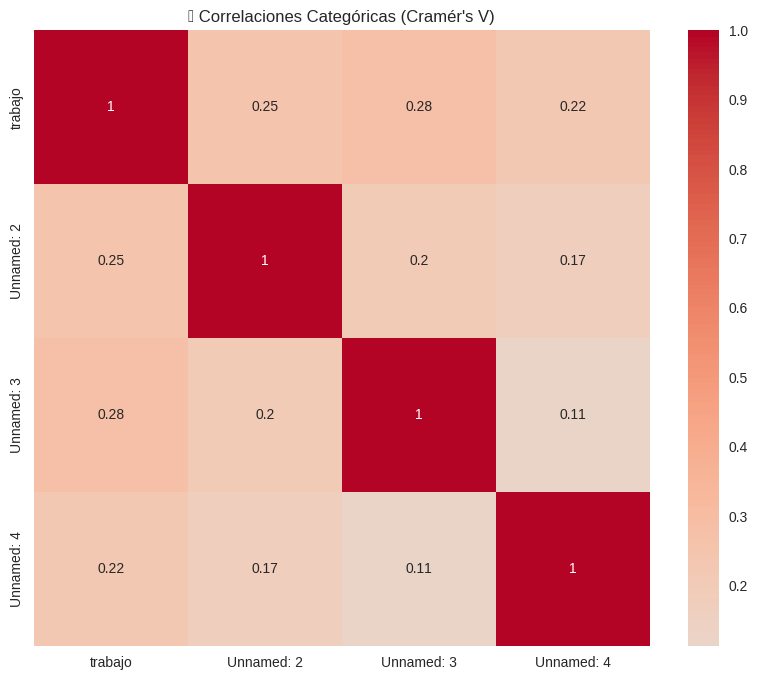

📋 Generando reporte completo...

📊 REPORTE COMPLETO DE ANÁLISIS NLP

📈 RESUMEN DEL DATASET:
   • Filas: 134
   • Columnas: 6
   • Completitud: 100.0%

🧠 INSIGHTS PRINCIPALES:
   • Clustering:
     - kmeans: 4 clusters
     - dbscan: 4 clusters
     - hierarchical: 4 clusters
   • Temas: 5
   • Mejor_Modelo:
     - nombre: Random Forest
     - accuracy: 0.741

💡 RECOMENDACIONES:
   1. Considerar aumentar el dataset si es posible para mejorar la robustez
   2. Explorar feature engineering adicional basado en los patrones encontrados
   3. Implementar validación cruzada para modelos más robustos
   4. Considerar técnicas de ensemble para mejorar el rendimiento predictivo


🎉 ¡ANÁLISIS COMPLETADO EXITOSAMENTE!


In [41]:
analyzer, report = run_complete_analysis(file_path='/content/drive/MyDrive/NLP/dataset1.csv')

# Task
Integrate a dendrogram plot based on Jaccard similarity into the existing NLP analysis code.

## Add a new method `calculate jaccard similarity`

### Subtask:
Implement a method within the `IntelligentNLPAnalyzer` class to calculate the pairwise Jaccard similarity (or distance) of the processed text data. This will likely involve tokenizing the `combined_text` and converting each document into a set of unique terms.


**Reasoning**:
Implement the `calculate_jaccard_similarity` method within the `IntelligentNLPAnalyzer` class as described in the instructions to calculate the pairwise Jaccard distance between processed text documents.



In [42]:
class IntelligentNLPAnalyzer:
    def __init__(self):
        self.data = None
        self.processed_data = None
        self.embeddings = None
        self.clusters = None
        self.nlp = spacy.load('es_core_news_sm')
        self.bert_model = None
        self.bert_tokenizer = None
        self.column_types = {}
        self.insights = {}
        self.jaccard_distance_matrix = None # New attribute for Jaccard distance

    def load_data(self, file_path, delimiter=';'):
        """Carga y analiza automáticamente la estructura del dataset"""
        print("🔍 Analizando estructura del dataset...")

        # Cargar datos
        self.data = pd.read_csv(file_path, delimiter=delimiter, encoding='latin-1')

        # Análisis automático de columnas
        self._infer_column_structure()
        self._analyze_data_quality()

        return self.data

    def _infer_column_structure(self):
        """Infiere automáticamente el tipo y propósito de cada columna"""
        print("🧠 Infiriendo estructura de columnas...")

        for col in self.data.columns:
            col_data = self.data[col].dropna()
            if len(col_data) == 0:
                self.column_types[col] = 'empty'
                continue

            # Análisis de patrones
            unique_ratio = len(col_data.unique()) / len(col_data)
            avg_length = col_data.astype(str).str.len().mean()

            # Detectar tipos de columna
            if col_data.dtype in ['int64', 'float64']:
                self.column_types[col] = 'numeric'
            elif unique_ratio < 0.1 and avg_length < 20:
                self.column_types[col] = 'categorical'
            elif avg_length > 50:
                self.column_types[col] = 'text_long'
            elif unique_ratio > 0.8:
                self.column_types[col] = 'identifier'
            else:
                self.column_types[col] = 'text_short'

        # Identificar columna objetivo (última columna con valores A/T)
        last_col = self.data.columns[-1]
        if set(self.data[last_col].dropna().unique()) <= {'A', 'T'}:
            self.column_types[last_col] = 'target'

        print(f"📊 Estructura inferida: {self.column_types}")

    def _analyze_data_quality(self):
        """Analiza la calidad de los datos"""
        print("🔎 Analizando calidad de datos...")

        quality_report = {
            'total_rows': len(self.data),
            'total_columns': len(self.data.columns),
            'missing_values': self.data.isnull().sum().to_dict(),
            'duplicate_rows': self.data.duplicated().sum(),
            'data_types': self.data.dtypes.to_dict()
        }

        self.insights['data_quality'] = quality_report

        # Crear visualización de calidad
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('📊 Análisis de Calidad de Datos', fontsize=16, fontweight='bold')

        # Missing values
        missing_data = pd.Series(quality_report['missing_values'])
        if missing_data[missing_data > 0].sum() > 0: # Check if there are any columns with missing values
            missing_data[missing_data > 0].plot(kind='bar', ax=axes[0,0])
            axes[0,0].set_title('Valores Faltantes por Columna')
            axes[0,0].tick_params(axis='x', rotation=45)
        else:
            axes[0,0].set_title('No hay Valores Faltantes') # Set a title indicating no missing values
            axes[0,0].axis('off') # Turn off axis if no missing values to plot


        # Distribución de tipos de columna
        type_counts = pd.Series(self.column_types).value_counts()
        axes[0,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Distribución de Tipos de Columna')

        # Estadísticas generales
        stats_text = f"""
        Filas Totales: {quality_report['total_rows']:,}
        Columnas Totales: {quality_report['total_columns']}
        Filas Duplicadas: {quality_report['duplicate_rows']}
        Completitud: {((1 - self.data.isnull().sum().sum() / (len(self.data) * len(self.data.columns))) * 100):.1f}%
        """
        axes[1,0].text(0.1, 0.5, stats_text, transform=axes[1,0].transAxes,
                      fontsize=12, verticalalignment='center')
        axes[1,0].set_title('Estadísticas Generales')
        axes[1,0].axis('off')

        # Heatmap de valores faltantes
        missing_matrix = self.data.isnull()
        sns.heatmap(missing_matrix, ax=axes[1,1], cbar=True, yticklabels=False)
        axes[1,1].set_title('Patrón de Valores Faltantes')

        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocesamiento inteligente de datos"""
        print("🔧 Iniciando preprocesamiento inteligente...")

        self.processed_data = self.data.copy()

        # Limpiar y normalizar por tipo de columna
        for col, col_type in self.column_types.items():
            if col_type == 'text_short' or col_type == 'text_long':
                self.processed_data[col] = self._clean_text_column(self.processed_data[col])
            elif col_type == 'categorical':
                self.processed_data[col] = self._clean_categorical_column(self.processed_data[col])

        # Crear columna de texto combinado para análisis NLP
        text_columns = [col for col, type_ in self.column_types.items()
                       if type_ in ['text_short', 'text_long', 'categorical']]

        if text_columns:
            self.processed_data['combined_text'] = self.processed_data[text_columns].fillna('').agg(' '.join, axis=1)
            self.processed_data['combined_text'] = self.processed_data['combined_text'].apply(self._clean_text)

        print(f"✅ Preprocesamiento completado. Shape: {self.processed_data.shape}")
        return self.processed_data

    def _clean_text_column(self, series):
        """Limpia una columna de texto"""
        return series.fillna('').astype(str).str.strip().str.lower()

    def _clean_categorical_column(self, series):
        """Limpia una columna categórica"""
        return series.fillna('desconocido').astype(str).str.strip().str.lower()

    def _clean_text(self, text):
        """Limpia texto individual"""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def generate_embeddings(self, method='bert'):
        """Genera embeddings usando BERT en español"""
        print(f"🤖 Generando embeddings usando {method.upper()}...")

        if 'combined_text' not in self.processed_data.columns:
            raise ValueError("Debe ejecutar preprocess_data() primero")

        texts = self.processed_data['combined_text'].tolist()

        if method == 'bert':
            # Cargar modelo BERT en español
            model_name = "dccuchile/bert-base-spanish-wwm-uncased"
            self.bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.bert_model = AutoModel.from_pretrained(model_name)

            embeddings = []
            batch_size = 32

            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                inputs = self.bert_tokenizer(batch_texts, return_tensors='pt',
                                           padding=True, truncation=True, max_length=512)

                with torch.no_grad():
                    outputs = self.bert_model(**inputs)
                    # Usar el embedding del token [CLS]
                    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
                    embeddings.extend(batch_embeddings)

                if (i // batch_size + 1) % 10 == 0:
                    print(f"   Procesado: {min(i + batch_size, len(texts))}/{len(texts)} textos")

            self.embeddings = np.array(embeddings)

        elif method == 'tfidf':
            vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
            self.embeddings = vectorizer.fit_transform(texts).toarray()

        print(f"✅ Embeddings generados. Shape: {self.embeddings.shape}")
        return self.embeddings

    def perform_clustering(self, n_clusters=None):
        """Realiza clustering no supervisado"""
        print("🎯 Realizando clustering no supervisado...")

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Si no se especifica número de clusters, usar método del codo
        if n_clusters is None:
            n_clusters = self._find_optimal_clusters()

        # Aplicar múltiples algoritmos de clustering
        clustering_results = {}

        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clustering_results['kmeans'] = kmeans.fit_predict(self.embeddings)

        # DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        clustering_results['dbscan'] = dbscan.fit_predict(self.embeddings)

        # Clustering Jerárquico
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        clustering_results['hierarchical'] = hierarchical.fit_predict(self.embeddings)

        # Agregar clusters al dataframe
        for method, labels in clustering_results.items():
            self.processed_data[f'cluster_{method}'] = labels

        self.clusters = clustering_results
        print(f"✅ Clustering completado con {n_clusters} clusters")

        # Visualizar resultados de clustering
        self._visualize_clustering()

        return clustering_results

    def _find_optimal_clusters(self):
        """Encuentra el número óptimo de clusters usando método del codo"""
        inertias = []
        k_range = range(2, min(11, len(self.embeddings) // 10))

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(self.embeddings)
            inertias.append(kmeans.inertia_)

        # Calcular segunda derivada para encontrar el codo
        if len(inertias) > 2:
            second_derivatives = np.diff(inertias, n=2)
            optimal_k = k_range[np.argmax(second_derivatives) + 1]
        else:
            optimal_k = k_range[0]

        print(f"📊 Número óptimo de clusters estimado: {optimal_k}")
        return optimal_k

    def _visualize_clustering(self):
        """Visualiza los resultados de clustering"""
        # Adjust perplexity based on the number of samples
        perplexity_value = min(30, len(self.embeddings) - 1)
        if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1


        if self.embeddings.shape[1] > 2:
            # Reducir dimensionalidad para visualización
            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
            embeddings_2d = tsne.fit_transform(self.embeddings)

            umap_reducer = umap.UMAP(n_components=2, random_state=42)
            embeddings_umap = umap_reducer.fit_transform(self.embeddings)
        else:
            embeddings_2d = self.embeddings
            embeddings_umap = self.embeddings

        # Crear subplots para diferentes métodos
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=['K-Means (t-SNE)', 'DBSCAN (t-SNE)', 'Hierarchical (t-SNE)',
                          'K-Means (UMAP)', 'DBSCAN (UMAP)', 'Hierarchical (UMAP)'],
            specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}],
                   [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]]
        )

        methods = ['kmeans', 'dbscan', 'hierarchical']
        embeddings_list = [embeddings_2d, embeddings_2d, embeddings_2d,
                          embeddings_umap, embeddings_umap, embeddings_umap]

        for i, method in enumerate(methods):
            if method in self.clusters:
                # t-SNE plots
                fig.add_trace(
                    go.Scatter(
                        x=embeddings_2d[:, 0],
                        y=embeddings_2d[:, 1],
                        mode='markers',
                        marker=dict(color=self.clusters[method], size=6, colorscale='viridis'),
                        name=f'{method.upper()}',
                        showlegend=False
                    ),
                    row=1, col=i+1
                )

                # UMAP plots
                fig.add_trace(
                    go.Scatter(
                        x=embeddings_umap[:, 0],
                        y=embeddings_umap[:, 1],
                        mode='markers',
                        marker=dict(color=self.clusters[method], size=6, colorscale='viridis'),
                        name=f'{method.upper()} UMAP',
                        showlegend=False
                    ),
                    row=2, col=i+1
                )

        fig.update_layout(height=800, title_text="🎯 Resultados de Clustering")
        fig.show()

    def topic_modeling(self, n_topics=5):
        """Realiza modelado de temas usando LDA"""
        print(f"📚 Realizando modelado de temas con {n_topics} tópicos...")

        # Preparar textos para LDA
        texts = self.processed_data['combined_text'].tolist()

        # Vectorización con filtros específicos para español
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000,
                                    stop_words=self._get_spanish_stopwords(),
                                    ngram_range=(1,2))
        doc_term_matrix = vectorizer.fit_transform(texts)

        # Aplicar LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(doc_term_matrix)

        # Extraer temas
        feature_names = vectorizer.get_feature_names_out()
        topics = {}

        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-10:]]
            topics[f'Tema_{topic_idx+1}'] = top_words

        # Asignar tema dominante a cada documento
        doc_topic_probs = lda.transform(doc_term_matrix)
        dominant_topics = doc_topic_probs.argmax(axis=1)
        self.processed_data['dominant_topic'] = dominant_topics

        self.insights['topics'] = topics

        # Visualizar temas
        self._visualize_topics(topics, doc_topic_probs)

        print("✅ Modelado de temas completado")
        return topics

    def _get_spanish_stopwords(self):
        """Retorna lista de stopwords en español"""
        spanish_stops = [
            'el', 'la', 'de', 'que', 'y', 'a', 'en', 'un', 'es', 'se', 'no', 'te', 'lo', 'le',
            'da', 'su', 'por', 'son', 'con', 'para', 'al', 'del', 'los', 'las', 'una', 'sobre',
            'todo', 'también', 'tras', 'otro', 'algún', 'poco', 'esta', 'estas', 'este', 'estos',
            'tan', 'entre', 'durante', 'desde', 'sin', 'bajo', 'hasta', 'según', 'muy', 'más'
        ]
        return spanish_stops

    def _visualize_topics(self, topics, doc_topic_probs):
        """Visualiza los temas encontrados"""
        # WordCloud para cada tema
        n_topics = len(topics)
        fig, axes = plt.subplots(2, (n_topics + 1) // 2, figsize=(15, 8))
        axes = axes.ravel()

        for i, (topic_name, words) in enumerate(topics.items()):
            wordcloud = WordCloud(width=300, height=200, background_color='white').generate(' '.join(words))
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{topic_name}')
            axes[i].axis('off')

        # Ocultar ejes sobrantes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.suptitle('☁️ Word Clouds por Tema', y=1.02, fontsize=16)
        plt.show()

        # Distribución de temas
        topic_distribution = pd.Series(self.processed_data['dominant_topic']).value_counts().sort_index()

        fig = go.Figure(data=[
            go.Bar(x=[f'Tema {i+1}' for i in topic_distribution.index],
                   y=topic_distribution.values)
        ])
        fig.update_layout(title='📊 Distribución de Documentos por Tema')
        fig.show()

    def similarity_analysis(self):
        """Análisis de similitud semántica"""
        print("🔍 Realizando análisis de similitud semántica...")

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Calcular matriz de similitud coseno
        similarity_matrix = cosine_similarity(self.embeddings)

        # Visualizar matriz de similitud
        plt.figure(figsize=(12, 10))
        sns.heatmap(similarity_matrix[:50, :50], cmap='coolwarm', center=0,
                   square=True, fmt='.2f')
        plt.title('🔥 Matriz de Similitud Semántica (primeras 50 muestras)')
        plt.show()

        # Encontrar pares más similares
        np.fill_diagonal(similarity_matrix, -1)  # Excluir auto-similitud
        most_similar_pairs = []

        for i in range(len(similarity_matrix)):
            max_sim_idx = np.argmax(similarity_matrix[i])
            if similarity_matrix[i, max_sim_idx] > 0.8:  # Threshold alto
                most_similar_pairs.append((i, max_sim_idx, similarity_matrix[i, max_sim_idx]))

        self.insights['similarity'] = {
            'matrix': similarity_matrix,
            'similar_pairs': most_similar_pairs
        }

        print(f"✅ Análisis completado. Encontrados {len(most_similar_pairs)} pares altamente similares")
        return similarity_matrix

    def build_semantic_network(self, threshold=0.7):
        """Construye red semántica basada en similitud"""
        print(f"🕸️ Construyendo red semántica con threshold {threshold}...")

        if 'similarity' not in self.insights:
            self.similarity_analysis()

        similarity_matrix = self.insights['similarity']['matrix']

        # Crear grafo
        G = nx.Graph()

        # Agregar nodos
        for i in range(len(similarity_matrix)):
            G.add_node(i)

        # Agregar aristas basadas en similitud
        for i in range(len(similarity_matrix)):
            for j in range(i+1, len(similarity_matrix)):
                if similarity_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=similarity_matrix[i, j])

        # Visualizar red
        plt.figure(figsize=(15, 12))
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Dibujar nodos y aristas
        nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue', alpha=0.7)
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

        plt.title('🕸️ Red Semántica basada en Similitud')
        plt.axis('off')
        plt.show()

        # Análisis de la red
        network_stats = {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'components': nx.number_connected_components(G)
        }

        print(f"📊 Estadísticas de la red: {network_stats}")
        return G

    def predictive_modeling(self):
        """Construye modelo predictivo para la etiqueta objetivo"""
        print("🎯 Construyendo modelos predictivos...")

        # Identificar columna objetivo
        target_column = None
        for col, col_type in self.column_types.items():
            if col_type == 'target':
                target_column = col
                break

        if target_column is None:
            print("⚠️ No se encontró columna objetivo")
            return None

        # Preparar datos
        X = self.embeddings
        y = self.processed_data[target_column].dropna()

        # Filtrar X para que coincida con y
        valid_indices = self.processed_data[target_column].dropna().index
        X = X[valid_indices]

        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

        # Entrenar múltiples modelos
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }

        results = {}

        for name, model in models.items():
            print(f"   Entrenando {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            results[name] = {
                'model': model,
                'predictions': y_pred,
                'report': classification_report(y_test, y_pred, output_dict=True)
            }

        # Visualizar resultados
        self._visualize_model_results(results, y_test, le)

        self.insights['predictive_models'] = results
        print("✅ Modelado predictivo completado")
        return results

    def _visualize_model_results(self, results, y_test, label_encoder):
        """Visualiza resultados de modelos predictivos"""
        fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
        if len(results) == 1:
            axes = [axes]

        for i, (model_name, result) in enumerate(results.items()):
            y_pred = result['predictions']
            cm = confusion_matrix(y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
            axes[i].set_title(f'{model_name}\nAccuracy: {result["report"]["accuracy"]:.3f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

            # Etiquetas
            labels = label_encoder.classes_
            axes[i].set_xticklabels(labels)
            axes[i].set_yticklabels(labels)

        plt.tight_layout()
        plt.suptitle('🎯 Matrices de Confusión - Modelos Predictivos', y=1.02)
        plt.show()

    def recommendation_system(self, index=0, top_k=5):
        """Sistema de recomendación basado en similitud"""
        print(f"💡 Generando recomendaciones para muestra {index}...")

        if 'similarity' not in self.insights:
            self.similarity_analysis()

        similarity_matrix = self.insights['similarity']['matrix']

        # Obtener similitudes para el índice dado
        similarities = similarity_matrix[index]

        # Encontrar los más similares (excluyendo el mismo)
        similarities[index] = -1
        top_indices = similarities.argsort()[-top_k:][::-1]

        # Crear DataFrame con recomendaciones
        recommendations = pd.DataFrame({
            'Índice': top_indices,
            'Similitud': similarities[top_indices],
            'Texto': [self.processed_data.iloc[i]['combined_text'][:100] + '...'
                     for i in top_indices]
        })

        print("🔍 Muestra de referencia:")
        print(f"   {self.processed_data.iloc[index]['combined_text'][:100]}...")
        print("\n💡 Recomendaciones:")
        for i, row in recommendations.iterrows():
            print(f"   {i+1}. Similitud: {row['Similitud']:.3f}")
            print(f"      {row['Texto']}")
            print()

        return recommendations

    def generate_comprehensive_report(self):
        """Genera reporte completo del análisis"""
        print("📋 Generando reporte completo...")

        report = {
            'resumen_dataset': {
                'filas': len(self.data),
                'columnas': len(self.data.columns),
                'tipos_columna': self.column_types,
                'completitud': f"{((1 - self.data.isnull().sum().sum() / (len(self.data) * len(self.data.columns))) * 100):.1f}%"
            },
            'insights_principales': {},
            'recomendaciones': []
        }

        # Análisis de clustering
        if self.clusters:
            cluster_info = {}
            for method, labels in self.clusters.items():
                unique_labels = len(set(labels))
                if -1 in labels:  # DBSCAN puede tener noise points
                    unique_labels -= 1
                cluster_info[method] = f"{unique_labels} clusters"
            report['insights_principales']['clustering'] = cluster_info

        # Análisis de temas
        if 'topics' in self.insights:
            report['insights_principales']['temas'] = len(self.insights['topics'])

        # Modelos predictivos
        if 'predictive_models' in self.insights:
            best_model = max(self.insights['predictive_models'].items(),
                           key=lambda x: x[1]['report']['accuracy'])
            report['insights_principales']['mejor_modelo'] = {
                'nombre': best_model[0],
                'accuracy': f"{best_model[1]['report']['accuracy']:.3f}"
            }

        # Generar recomendaciones
        report['recomendaciones'] = [
            "Considerar aumentar el dataset si es posible para mejorar la robustez",
            "Explorar feature engineering adicional basado en los patrones encontrados",
            "Implementar validación cruzada para modelos más robustos",
            "Considerar técnicas de ensemble para mejorar el rendimiento predictivo"
        ]

        # Mostrar reporte
        print("\n" + "="*60)
        print("📊 REPORTE COMPLETO DE ANÁLISIS NLP")
        print("="*60)

        print(f"\n📈 RESUMEN DEL DATASET:")
        print(f"   • Filas: {report['resumen_dataset']['filas']:,}")
        print(f"   • Columnas: {report['resumen_dataset']['columnas']}")
        print(f"   • Completitud: {report['resumen_dataset']['completitud']}")

        print(f"\n🧠 INSIGHTS PRINCIPALES:")
        for key, value in report['insights_principales'].items():
            if isinstance(value, dict):
                print(f"   • {key.title()}:")
                for k, v in value.items():
                    print(f"     - {k}: {v}")
            else:
                print(f"   • {key.title()}: {value}")

        print(f"\n💡 RECOMENDACIONES:")
        for i, rec in enumerate(report['recomendaciones'], 1):
            print(f"   {i}. {rec}")

        print("\n" + "="*60)

        return report

    def anomaly_detection(self, contamination=0.1):
        """Detecta anomalías en los datos"""
        print("🚨 Realizando detección de anomalías...")

        from sklearn.ensemble import IsolationForest
        from sklearn.preprocessing import StandardScaler

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Normalizar embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(self.embeddings)

        # Aplicar Isolation Forest
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        anomaly_labels = iso_forest.fit_predict(embeddings_scaled)

        # Añadir etiquetas al dataset
        self.processed_data['is_anomaly'] = anomaly_labels == -1

        # Análisis de anomalías
        n_anomalies = sum(anomaly_labels == -1)
        anomaly_rate = n_anomalies / len(anomaly_labels) * 100

        print(f"🔍 Detectadas {n_anomalies} anomalías ({anomaly_rate:.1f}% del dataset)")

        # Visualizar anomalías
        if self.embeddings.shape[1] > 2:
            # Adjust perplexity based on the number of samples
            perplexity_value = min(30, len(embeddings_scaled) - 1)
            if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1

            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
            embeddings_2d = tsne.fit_transform(embeddings_scaled)
        else:
            embeddings_2d = embeddings_scaled

        plt.figure(figsize=(12, 8))

        # Puntos normales
        normal_mask = anomaly_labels == 1
        plt.scatter(embeddings_2d[normal_mask, 0], embeddings_2d[normal_mask, 1],
                   c='blue', alpha=0.6, label='Normal', s=50)

        # Anomalías
        anomaly_mask = anomaly_labels == -1
        plt.scatter(embeddings_2d[anomaly_mask, 0], embeddings_2d[anomaly_mask, 1],
                   c='red', alpha=0.8, label='Anomalía', s=100, marker='x')

        plt.title('🚨 Detección de Anomalías (t-SNE)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Mostrar ejemplos de anomalías
        anomaly_indices = self.processed_data[self.processed_data['is_anomaly']].index[:5]
        print("\n🔍 Ejemplos de anomalías detectadas:")
        for i, idx in enumerate(anomaly_indices, 1):
            text = self.processed_data.iloc[idx]['combined_text'][:100]
            print(f"   {i}. Índice {idx}: {text}...")

        return anomaly_labels

    def advanced_visualizations(self):
        """Genera visualizaciones avanzadas interactivas"""
        print("📊 Generando visualizaciones avanzadas...")

        # 1. Dashboard interactivo con plotly
        if self.clusters and 'combined_text' in self.processed_data.columns:
            self._create_interactive_dashboard()

        # 2. Análisis temporal si hay patrones temporales
        self._analyze_temporal_patterns()

        # 3. Análisis de correlaciones categóricas
        self._analyze_categorical_correlations()

    def _create_interactive_dashboard(self):
        """Crea dashboard interactivo"""
        # Adjust perplexity based on the number of samples
        perplexity_value = min(30, len(self.embeddings) - 1)
        if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1

        # Reducir dimensionalidad para visualización
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
        embeddings_2d = tsne.fit_transform(self.embeddings)

        # Crear DataFrame para plotly
        viz_data = pd.DataFrame({
            'x': embeddings_2d[:, 0],
            'y': embeddings_2d[:, 1],
            'cluster_kmeans': self.processed_data['cluster_kmeans'],
            'text_preview': [text[:100] + '...' for text in self.processed_data['combined_text']],
            'index': range(len(embeddings_2d))
        })

        # Agregar información adicional si existe
        if 'dominant_topic' in self.processed_data.columns:
            viz_data['topic'] = self.processed_data['dominant_topic']

        # Crear figura interactiva
        fig = px.scatter(
            viz_data,
            x='x', y='y',
            color='cluster_kmeans',
            hover_data=['index', 'text_preview'],
            title='🎯 Visualización Interactiva de Clusters (t-SNE)',
            color_continuous_scale='viridis'
        )

        fig.update_traces(marker=dict(size=8, opacity=0.7))
        fig.update_layout(height=600)
        fig.show()

    def _analyze_temporal_patterns(self):
        """Analiza patrones temporales si existen"""
        # Buscar columnas que podrían ser temporales
        date_patterns = []
        for col in self.data.columns:
            if self.data[col].dtype == 'object':
                sample_values = self.data[col].dropna().astype(str).head(10)
                # Buscar patrones de fecha
                date_like = sum(1 for val in sample_values
                              if re.search(r'\d{2,4}[-/]\d{1,2}[-/]\d{1,4}', str(val)))
                if date_like > 5:  # Al menos 50% parecen fechas
                    date_patterns.append(col)

        if date_patterns:
            print(f"📅 Encontradas posibles columnas temporales: {date_patterns}")
            # Aquí podrías agregar análisis temporal específico
        else:
            print("📅 No se detectaron patrones temporales claros")

    def _analyze_categorical_correlations(self):
        """Analiza correlaciones entre variables categóricas"""
        categorical_cols = [col for col, col_type in self.column_types.items()
                          if col_type == 'categorical']

        if len(categorical_cols) > 1:
            print("🔗 Analizando correlaciones categóricas...")

            # Crear matriz de correlación usando Cramér's V
            from scipy.stats import chi2_contingency

            corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

            for col1 in categorical_cols:
                for col2 in categorical_cols:
                    if col1 == col2:
                        corr_matrix.loc[col1, col2] = 1.0
                    else:
                        # Crear tabla de contingencia
                        contingency = pd.crosstab(self.processed_data[col1],
                                                self.processed_data[col2])

                        # Calcular Cramér's V
                        chi2, _, _, _ = chi2_contingency(contingency)
                        n = contingency.sum().sum()
                        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
                        corr_matrix.loc[col1, col2] = cramers_v

            # Visualizar correlaciones categóricas
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm',
                       center=0, square=True)
            plt.title('🔗 Correlaciones Categóricas (Cramér\'s V)')
            plt.show()

    def calculate_jaccard_similarity(self):
        """Calcula la distancia de Jaccard entre documentos"""
        print("📐 Calculando distancia de Jaccard...")

        if self.processed_data is None or 'combined_text' not in self.processed_data.columns:
            raise ValueError("Debe ejecutar preprocess_data() primero y asegurar que 'combined_text' existe.")

        texts = self.processed_data['combined_text'].tolist()
        token_sets = [set(text.split()) for text in texts]

        n_samples = len(token_sets)
        self.jaccard_distance_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(i, n_samples):
                set1 = token_sets[i]
                set2 = token_sets[j]

                if not set1 and not set2:
                    distance = 0.0
                else:
                    intersection = len(set1.intersection(set2))
                    union = len(set1.union(set2))
                    distance = 1.0 - (intersection / union)

                self.jaccard_distance_matrix[i, j] = distance
                self.jaccard_distance_matrix[j, i] = distance # Matrix is symmetric

        print(f"✅ Distancia de Jaccard calculada. Shape: {self.jaccard_distance_matrix.shape}")
        return self.jaccard_distance_matrix

## Plot dendrogram

### Subtask:
Implement a method within the `IntelligentNLPAnalyzer` class that takes the Jaccard distance matrix, performs hierarchical clustering using `scipy.cluster.hierarchy`, and plots the resulting dendrogram using `matplotlib.pyplot`.


**Reasoning**:
Implement the `plot_dendrogram` method within the `IntelligentNLPAnalyzer` class as described in the instructions.



In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

class IntelligentNLPAnalyzer:
    def __init__(self):
        self.data = None
        self.processed_data = None
        self.embeddings = None
        self.clusters = None
        self.nlp = spacy.load('es_core_news_sm')
        self.bert_model = None
        self.bert_tokenizer = None
        self.column_types = {}
        self.insights = {}
        self.jaccard_distance_matrix = None

    def load_data(self, file_path, delimiter=';'):
        """Carga y analiza automáticamente la estructura del dataset"""
        print("🔍 Analizando estructura del dataset...")

        # Cargar datos
        self.data = pd.read_csv(file_path, delimiter=delimiter, encoding='latin-1')

        # Análisis automático de columnas
        self._infer_column_structure()
        self._analyze_data_quality()

        return self.data

    def _infer_column_structure(self):
        """Infiere automáticamente el tipo y propósito de cada columna"""
        print("🧠 Infiriendo estructura de columnas...")

        for col in self.data.columns:
            col_data = self.data[col].dropna()
            if len(col_data) == 0:
                self.column_types[col] = 'empty'
                continue

            # Análisis de patrones
            unique_ratio = len(col_data.unique()) / len(col_data)
            avg_length = col_data.astype(str).str.len().mean()

            # Detectar tipos de columna
            if col_data.dtype in ['int64', 'float64']:
                self.column_types[col] = 'numeric'
            elif unique_ratio < 0.1 and avg_length < 20:
                self.column_types[col] = 'categorical'
            elif avg_length > 50:
                self.column_types[col] = 'text_long'
            elif unique_ratio > 0.8:
                self.column_types[col] = 'identifier'
            else:
                self.column_types[col] = 'text_short'

        # Identificar columna objetivo (última columna con valores A/T)
        last_col = self.data.columns[-1]
        if set(self.data[last_col].dropna().unique()) <= {'A', 'T'}:
            self.column_types[last_col] = 'target'

        print(f"📊 Estructura inferida: {self.column_types}")

    def _analyze_data_quality(self):
        """Analiza la calidad de los datos"""
        print("🔎 Analizando calidad de datos...")

        quality_report = {
            'total_rows': len(self.data),
            'total_columns': len(self.data.columns),
            'missing_values': self.data.isnull().sum().to_dict(),
            'duplicate_rows': self.data.duplicated().sum(),
            'data_types': self.data.dtypes.to_dict()
        }

        self.insights['data_quality'] = quality_report

        # Crear visualización de calidad
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('📊 Análisis de Calidad de Datos', fontsize=16, fontweight='bold')

        # Missing values
        missing_data = pd.Series(quality_report['missing_values'])
        if missing_data[missing_data > 0].sum() > 0: # Check if there are any columns with missing values
            missing_data[missing_data > 0].plot(kind='bar', ax=axes[0,0])
            axes[0,0].set_title('Valores Faltantes por Columna')
            axes[0,0].tick_params(axis='x', rotation=45)
        else:
            axes[0,0].set_title('No hay Valores Faltantes') # Set a title indicating no missing values
            axes[0,0].axis('off') # Turn off axis if no missing values to plot


        # Distribución de tipos de columna
        type_counts = pd.Series(self.column_types).value_counts()
        axes[0,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Distribución de Tipos de Columna')

        # Estadísticas generales
        stats_text = f"""
        Filas Totales: {quality_report['total_rows']:,}
        Columnas Totales: {quality_report['total_columns']}
        Filas Duplicadas: {quality_report['duplicate_rows']}
        Completitud: {((1 - self.data.isnull().sum().sum() / (len(self.data) * len(self.data.columns))) * 100):.1f}%
        """
        axes[1,0].text(0.1, 0.5, stats_text, transform=axes[1,0].transAxes,
                      fontsize=12, verticalalignment='center')
        axes[1,0].set_title('Estadísticas Generales')
        axes[1,0].axis('off')

        # Heatmap de valores faltantes
        missing_matrix = self.data.isnull()
        sns.heatmap(missing_matrix, ax=axes[1,1], cbar=True, yticklabels=False)
        axes[1,1].set_title('Patrón de Valores Faltantes')

        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocesamiento inteligente de datos"""
        print("🔧 Iniciando preprocesamiento inteligente...")

        self.processed_data = self.data.copy()

        # Limpiar y normalizar por tipo de columna
        for col, col_type in self.column_types.items():
            if col_type == 'text_short' or col_type == 'text_long':
                self.processed_data[col] = self._clean_text_column(self.processed_data[col])
            elif col_type == 'categorical':
                self.processed_data[col] = self._clean_categorical_column(self.processed_data[col])

        # Crear columna de texto combinado para análisis NLP
        text_columns = [col for col, type_ in self.column_types.items()
                       if type_ in ['text_short', 'text_long', 'categorical']]

        if text_columns:
            self.processed_data['combined_text'] = self.processed_data[text_columns].fillna('').agg(' '.join, axis=1)
            self.processed_data['combined_text'] = self.processed_data['combined_text'].apply(self._clean_text)

        print(f"✅ Preprocesamiento completado. Shape: {self.processed_data.shape}")
        return self.processed_data

    def _clean_text_column(self, series):
        """Limpia una columna de texto"""
        return series.fillna('').astype(str).str.strip().str.lower()

    def _clean_categorical_column(self, series):
        """Limpia una columna categórica"""
        return series.fillna('desconocido').astype(str).str.strip().str.lower()

    def _clean_text(self, text):
        """Limpia texto individual"""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def generate_embeddings(self, method='bert'):
        """Genera embeddings usando BERT en español"""
        print(f"🤖 Generando embeddings usando {method.upper()}...")

        if 'combined_text' not in self.processed_data.columns:
            raise ValueError("Debe ejecutar preprocess_data() primero")

        texts = self.processed_data['combined_text'].tolist()

        if method == 'bert':
            # Cargar modelo BERT en español
            model_name = "dccuchile/bert-base-spanish-wwm-uncased"
            self.bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.bert_model = AutoModel.from_pretrained(model_name)

            embeddings = []
            batch_size = 32

            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                inputs = self.bert_tokenizer(batch_texts, return_tensors='pt',
                                           padding=True, truncation=True, max_length=512)

                with torch.no_grad():
                    outputs = self.bert_model(**inputs)
                    # Usar el embedding del token [CLS]
                    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
                    embeddings.extend(batch_embeddings)

                if (i // batch_size + 1) % 10 == 0:
                    print(f"   Procesado: {min(i + batch_size, len(texts))}/{len(texts)} textos")

            self.embeddings = np.array(embeddings)

        elif method == 'tfidf':
            vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
            self.embeddings = vectorizer.fit_transform(texts).toarray()

        print(f"✅ Embeddings generados. Shape: {self.embeddings.shape}")
        return self.embeddings

    def perform_clustering(self, n_clusters=None):
        """Realiza clustering no supervisado"""
        print("🎯 Realizando clustering no supervisado...")

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Si no se especifica número de clusters, usar método del codo
        if n_clusters is None:
            n_clusters = self._find_optimal_clusters()

        # Aplicar múltiples algoritmos de clustering
        clustering_results = {}

        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clustering_results['kmeans'] = kmeans.fit_predict(self.embeddings)

        # DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        clustering_results['dbscan'] = dbscan.fit_predict(self.embeddings)

        # Clustering Jerárquico
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        clustering_results['hierarchical'] = hierarchical.fit_predict(self.embeddings)

        # Agregar clusters al dataframe
        for method, labels in clustering_results.items():
            self.processed_data[f'cluster_{method}'] = labels

        self.clusters = clustering_results
        print(f"✅ Clustering completado con {n_clusters} clusters")

        # Visualizar resultados de clustering
        self._visualize_clustering()

        return clustering_results

    def _find_optimal_clusters(self):
        """Encuentra el número óptimo de clusters usando método del codo"""
        inertias = []
        k_range = range(2, min(11, len(self.embeddings) // 10))

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(self.embeddings)
            inertias.append(kmeans.inertia_)

        # Calcular segunda derivada para encontrar el codo
        if len(inertias) > 2:
            second_derivatives = np.diff(inertias, n=2)
            optimal_k = k_range[np.argmax(second_derivatives) + 1]
        else:
            optimal_k = k_range[0]

        print(f"📊 Número óptimo de clusters estimado: {optimal_k}")
        return optimal_k

    def _visualize_clustering(self):
        """Visualiza los resultados de clustering"""
        # Adjust perplexity based on the number of samples
        perplexity_value = min(30, len(self.embeddings) - 1)
        if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1


        if self.embeddings.shape[1] > 2:
            # Reducir dimensionalidad para visualización
            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
            embeddings_2d = tsne.fit_transform(self.embeddings)

            umap_reducer = umap.UMAP(n_components=2, random_state=42)
            embeddings_umap = umap_reducer.fit_transform(self.embeddings)
        else:
            embeddings_2d = self.embeddings
            embeddings_umap = self.embeddings

        # Crear subplots para diferentes métodos
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=['K-Means (t-SNE)', 'DBSCAN (t-SNE)', 'Hierarchical (t-SNE)',
                          'K-Means (UMAP)', 'DBSCAN (UMAP)', 'Hierarchical (UMAP)'],
            specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}],
                   [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]]
        )

        methods = ['kmeans', 'dbscan', 'hierarchical']
        embeddings_list = [embeddings_2d, embeddings_2d, embeddings_2d,
                          embeddings_umap, embeddings_umap, embeddings_umap]

        for i, method in enumerate(methods):
            if method in self.clusters:
                # t-SNE plots
                fig.add_trace(
                    go.Scatter(
                        x=embeddings_2d[:, 0],
                        y=embeddings_2d[:, 1],
                        mode='markers',
                        marker=dict(color=self.clusters[method], size=6, colorscale='viridis'),
                        name=f'{method.upper()}',
                        showlegend=False
                    ),
                    row=1, col=i+1
                )

                # UMAP plots
                fig.add_trace(
                    go.Scatter(
                        x=embeddings_umap[:, 0],
                        y=embeddings_umap[:, 1],
                        mode='markers',
                        marker=dict(color=self.clusters[method], size=6, colorscale='viridis'),
                        name=f'{method.upper()} UMAP',
                        showlegend=False
                    ),
                    row=2, col=i+1
                )

        fig.update_layout(height=800, title_text="🎯 Resultados de Clustering")
        fig.show()

    def topic_modeling(self, n_topics=5):
        """Realiza modelado de temas usando LDA"""
        print(f"📚 Realizando modelado de temas con {n_topics} tópicos...")

        # Preparar textos para LDA
        texts = self.processed_data['combined_text'].tolist()

        # Vectorización con filtros específicos para español
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000,
                                    stop_words=self._get_spanish_stopwords(),
                                    ngram_range=(1,2))
        doc_term_matrix = vectorizer.fit_transform(texts)

        # Aplicar LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(doc_term_matrix)

        # Extraer temas
        feature_names = vectorizer.get_feature_names_out()
        topics = {}

        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-10:]]
            topics[f'Tema_{topic_idx+1}'] = top_words

        # Asignar tema dominante a cada documento
        doc_topic_probs = lda.transform(doc_term_matrix)
        dominant_topics = doc_topic_probs.argmax(axis=1)
        self.processed_data['dominant_topic'] = dominant_topics

        self.insights['topics'] = topics

        # Visualizar temas
        self._visualize_topics(topics, doc_topic_probs)

        print("✅ Modelado de temas completado")
        return topics

    def _get_spanish_stopwords(self):
        """Retorna lista de stopwords en español"""
        spanish_stops = [
            'el', 'la', 'de', 'que', 'y', 'a', 'en', 'un', 'es', 'se', 'no', 'te', 'lo', 'le',
            'da', 'su', 'por', 'son', 'con', 'para', 'al', 'del', 'los', 'las', 'una', 'sobre',
            'todo', 'también', 'tras', 'otro', 'algún', 'poco', 'esta', 'estas', 'este', 'estos',
            'tan', 'entre', 'durante', 'desde', 'sin', 'bajo', 'hasta', 'según', 'muy', 'más'
        ]
        return spanish_stops

    def _visualize_topics(self, topics, doc_topic_probs):
        """Visualiza los temas encontrados"""
        # WordCloud para cada tema
        n_topics = len(topics)
        fig, axes = plt.subplots(2, (n_topics + 1) // 2, figsize=(15, 8))
        axes = axes.ravel()

        for i, (topic_name, words) in enumerate(topics.items()):
            wordcloud = WordCloud(width=300, height=200, background_color='white').generate(' '.join(words))
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{topic_name}')
            axes[i].axis('off')

        # Ocultar ejes sobrantes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.suptitle('☁️ Word Clouds por Tema', y=1.02, fontsize=16)
        plt.show()

        # Distribución de temas
        topic_distribution = pd.Series(self.processed_data['dominant_topic']).value_counts().sort_index()

        fig = go.Figure(data=[
            go.Bar(x=[f'Tema {i+1}' for i in topic_distribution.index],
                   y=topic_distribution.values)
        ])
        fig.update_layout(title='📊 Distribución de Documentos por Tema')
        fig.show()

    def similarity_analysis(self):
        """Análisis de similitud semántica"""
        print("🔍 Realizando análisis de similitud semántica...")

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Calcular matriz de similitud coseno
        similarity_matrix = cosine_similarity(self.embeddings)

        # Visualizar matriz de similitud
        plt.figure(figsize=(12, 10))
        sns.heatmap(similarity_matrix[:50, :50], cmap='coolwarm', center=0,
                   square=True, fmt='.2f')
        plt.title('🔥 Matriz de Similitud Semántica (primeras 50 muestras)')
        plt.show()

        # Encontrar pares más similares
        np.fill_diagonal(similarity_matrix, -1)  # Excluir auto-similitud
        most_similar_pairs = []

        for i in range(len(similarity_matrix)):
            max_sim_idx = np.argmax(similarity_matrix[i])
            if similarity_matrix[i, max_sim_idx] > 0.8:  # Threshold alto
                most_similar_pairs.append((i, max_sim_idx, similarity_matrix[i, max_sim_idx]))

        self.insights['similarity'] = {
            'matrix': similarity_matrix,
            'similar_pairs': most_similar_pairs
        }

        print(f"✅ Análisis completado. Encontrados {len(most_similar_pairs)} pares altamente similares")
        return similarity_matrix

    def build_semantic_network(self, threshold=0.7):
        """Construye red semántica basada en similitud"""
        print(f"🕸️ Construyendo red semántica con threshold {threshold}...")

        if 'similarity' not in self.insights:
            self.similarity_analysis()

        similarity_matrix = self.insights['similarity']['matrix']

        # Crear grafo
        G = nx.Graph()

        # Agregar nodos
        for i in range(len(similarity_matrix)):
            G.add_node(i)

        # Agregar aristas basadas en similitud
        for i in range(len(similarity_matrix)):
            for j in range(i+1, len(similarity_matrix)):
                if similarity_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=similarity_matrix[i, j])

        # Visualizar red
        plt.figure(figsize=(15, 12))
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Dibujar nodos y aristas
        nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue', alpha=0.7)
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

        plt.title('🕸️ Red Semántica basada en Similitud')
        plt.axis('off')
        plt.show()

        # Análisis de la red
        network_stats = {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'components': nx.number_connected_components(G)
        }

        print(f"📊 Estadísticas de la red: {network_stats}")
        return G

    def predictive_modeling(self):
        """Construye modelo predictivo para la etiqueta objetivo"""
        print("🎯 Construyendo modelos predictivos...")

        # Identificar columna objetivo
        target_column = None
        for col, col_type in self.column_types.items():
            if col_type == 'target':
                target_column = col
                break

        if target_column is None:
            print("⚠️ No se encontró columna objetivo")
            return None

        # Preparar datos
        X = self.embeddings
        y = self.processed_data[target_column].dropna()

        # Filtrar X para que coincida con y
        valid_indices = self.processed_data[target_column].dropna().index
        X = X[valid_indices]

        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

        # Entrenar múltiples modelos
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }

        results = {}

        for name, model in models.items():
            print(f"   Entrenando {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            results[name] = {
                'model': model,
                'predictions': y_pred,
                'report': classification_report(y_test, y_pred, output_dict=True)
            }

        # Visualizar resultados
        self._visualize_model_results(results, y_test, le)

        self.insights['predictive_models'] = results
        print("✅ Modelado predictivo completado")
        return results

    def _visualize_model_results(self, results, y_test, label_encoder):
        """Visualiza resultados de modelos predictivos"""
        fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
        if len(results) == 1:
            axes = [axes]

        for i, (model_name, result) in enumerate(results.items()):
            y_pred = result['predictions']
            cm = confusion_matrix(y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
            axes[i].set_title(f'{model_name}\nAccuracy: {result["report"]["accuracy"]:.3f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

            # Etiquetas
            labels = label_encoder.classes_
            axes[i].set_xticklabels(labels)
            axes[i].set_yticklabels(labels)

        plt.tight_layout()
        plt.suptitle('🎯 Matrices de Confusión - Modelos Predictivos', y=1.02)
        plt.show()

    def recommendation_system(self, index=0, top_k=5):
        """Sistema de recomendación basado en similitud"""
        print(f"💡 Generando recomendaciones para muestra {index}...")

        if 'similarity' not in self.insights:
            self.similarity_analysis()

        similarity_matrix = self.insights['similarity']['matrix']

        # Obtener similitudes para el índice dado
        similarities = similarity_matrix[index]

        # Encontrar los más similares (excluyendo el mismo)
        similarities[index] = -1
        top_indices = similarities.argsort()[-top_k:][::-1]

        # Crear DataFrame con recomendaciones
        recommendations = pd.DataFrame({
            'Índice': top_indices,
            'Similitud': similarities[top_indices],
            'Texto': [self.processed_data.iloc[i]['combined_text'][:100] + '...'
                     for i in top_indices]
        })

        print("🔍 Muestra de referencia:")
        print(f"   {self.processed_data.iloc[index]['combined_text'][:100]}...")
        print("\n💡 Recomendaciones:")
        for i, row in recommendations.iterrows():
            print(f"   {i+1}. Similitud: {row['Similitud']:.3f}")
            print(f"      {row['Texto']}")
            print()

        return recommendations

    def generate_comprehensive_report(self):
        """Genera reporte completo del análisis"""
        print("📋 Generando reporte completo...")

        report = {
            'resumen_dataset': {
                'filas': len(self.data),
                'columnas': len(self.data.columns),
                'tipos_columna': self.column_types,
                'completitud': f"{((1 - self.data.isnull().sum().sum() / (len(self.data) * len(self.data.columns))) * 100):.1f}%"
            },
            'insights_principales': {},
            'recomendaciones': []
        }

        # Análisis de clustering
        if self.clusters:
            cluster_info = {}
            for method, labels in self.clusters.items():
                unique_labels = len(set(labels))
                if -1 in labels:  # DBSCAN puede tener noise points
                    unique_labels -= 1
                cluster_info[method] = f"{unique_labels} clusters"
            report['insights_principales']['clustering'] = cluster_info

        # Análisis de temas
        if 'topics' in self.insights:
            report['insights_principales']['temas'] = len(self.insights['topics'])

        # Modelos predictivos
        if 'predictive_models' in self.insights:
            best_model = max(self.insights['predictive_models'].items(),
                           key=lambda x: x[1]['report']['accuracy'])
            report['insights_principales']['mejor_modelo'] = {
                'nombre': best_model[0],
                'accuracy': f"{best_model[1]['report']['accuracy']:.3f}"
            }

        # Generar recomendaciones
        report['recomendaciones'] = [
            "Considerar aumentar el dataset si es posible para mejorar la robustez",
            "Explorar feature engineering adicional basado en los patrones encontrados",
            "Implementar validación cruzada para modelos más robustos",
            "Considerar técnicas de ensemble para mejorar el rendimiento predictivo"
        ]

        # Mostrar reporte
        print("\n" + "="*60)
        print("📊 REPORTE COMPLETO DE ANÁLISIS NLP")
        print("="*60)

        print(f"\n📈 RESUMEN DEL DATASET:")
        print(f"   • Filas: {report['resumen_dataset']['filas']:,}")
        print(f"   • Columnas: {report['resumen_dataset']['columnas']}")
        print(f"   • Completitud: {report['resumen_dataset']['completitud']}")

        print(f"\n🧠 INSIGHTS PRINCIPALES:")
        for key, value in report['insights_principales'].items():
            if isinstance(value, dict):
                print(f"   • {key.title()}:")
                for k, v in value.items():
                    print(f"     - {k}: {v}")
            else:
                print(f"   • {key.title()}: {value}")

        print(f"\n💡 RECOMENDACIONES:")
        for i, rec in enumerate(report['recomendaciones'], 1):
            print(f"   {i}. {rec}")

        print("\n" + "="*60)

        return report

    def anomaly_detection(self, contamination=0.1):
        """Detecta anomalías en los datos"""
        print("🚨 Realizando detección de anomalías...")

        from sklearn.ensemble import IsolationForest
        from sklearn.preprocessing import StandardScaler

        if self.embeddings is None:
            raise ValueError("Debe generar embeddings primero")

        # Normalizar embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(self.embeddings)

        # Aplicar Isolation Forest
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        anomaly_labels = iso_forest.fit_predict(embeddings_scaled)

        # Añadir etiquetas al dataset
        self.processed_data['is_anomaly'] = anomaly_labels == -1

        # Análisis de anomalías
        n_anomalies = sum(anomaly_labels == -1)
        anomaly_rate = n_anomalies / len(anomaly_labels) * 100

        print(f"🔍 Detectadas {n_anomalies} anomalías ({anomaly_rate:.1f}% del dataset)")

        # Visualizar anomalías
        if self.embeddings.shape[1] > 2:
            # Adjust perplexity based on the number of samples
            perplexity_value = min(30, len(embeddings_scaled) - 1)
            if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1

            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
            embeddings_2d = tsne.fit_transform(embeddings_scaled)
        else:
            embeddings_2d = embeddings_scaled

        plt.figure(figsize=(12, 8))

        # Puntos normales
        normal_mask = anomaly_labels == 1
        plt.scatter(embeddings_2d[normal_mask, 0], embeddings_2d[normal_mask, 1],
                   c='blue', alpha=0.6, label='Normal', s=50)

        # Anomalías
        anomaly_mask = anomaly_labels == -1
        plt.scatter(embeddings_2d[anomaly_mask, 0], embeddings_2d[anomaly_mask, 1],
                   c='red', alpha=0.8, label='Anomalía', s=100, marker='x')

        plt.title('🚨 Detección de Anomalías (t-SNE)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Mostrar ejemplos de anomalías
        anomaly_indices = self.processed_data[self.processed_data['is_anomaly']].index[:5]
        print("\n🔍 Ejemplos de anomalías detectadas:")
        for i, idx in enumerate(anomaly_indices, 1):
            text = self.processed_data.iloc[idx]['combined_text'][:100]
            print(f"   {i}. Índice {idx}: {text}...")

        return anomaly_labels

    def advanced_visualizations(self):
        """Genera visualizaciones avanzadas interactivas"""
        print("📊 Generando visualizaciones avanzadas...")

        # 1. Dashboard interactivo con plotly
        if self.clusters and 'combined_text' in self.processed_data.columns:
            self._create_interactive_dashboard()

        # 2. Análisis temporal si hay patrones temporales
        self._analyze_temporal_patterns()

        # 3. Análisis de correlaciones categóricas
        self._analyze_categorical_correlations()

    def _create_interactive_dashboard(self):
        """Crea dashboard interactivo"""
        # Adjust perplexity based on the number of samples
        perplexity_value = min(30, len(self.embeddings) - 1)
        if perplexity_value < 1: perplexity_value = 1 # ensure perplexity is at least 1

        # Reducir dimensionalidad para visualización
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
        embeddings_2d = tsne.fit_transform(self.embeddings)

        # Crear DataFrame para plotly
        viz_data = pd.DataFrame({
            'x': embeddings_2d[:, 0],
            'y': embeddings_2d[:, 1],
            'cluster_kmeans': self.processed_data['cluster_kmeans'],
            'text_preview': [text[:100] + '...' for text in self.processed_data['combined_text']],
            'index': range(len(embeddings_2d))
        })

        # Agregar información adicional si existe
        if 'dominant_topic' in self.processed_data.columns:
            viz_data['topic'] = self.processed_data['dominant_topic']

        # Crear figura interactiva
        fig = px.scatter(
            viz_data,
            x='x', y='y',
            color='cluster_kmeans',
            hover_data=['index', 'text_preview'],
            title='🎯 Visualización Interactiva de Clusters (t-SNE)',
            color_continuous_scale='viridis'
        )

        fig.update_traces(marker=dict(size=8, opacity=0.7))
        fig.update_layout(height=600)
        fig.show()

    def _analyze_temporal_patterns(self):
        """Analiza patrones temporales si existen"""
        # Buscar columnas que podrían ser temporales
        date_patterns = []
        for col in self.data.columns:
            if self.data[col].dtype == 'object':
                sample_values = self.data[col].dropna().astype(str).head(10)
                # Buscar patrones de fecha
                date_like = sum(1 for val in sample_values
                              if re.search(r'\d{2,4}[-/]\d{1,2}[-/]\d{1,4}', str(val)))
                if date_like > 5:  # Al menos 50% parecen fechas
                    date_patterns.append(col)

        if date_patterns:
            print(f"📅 Encontradas posibles columnas temporales: {date_patterns}")
            # Aquí podrías agregar análisis temporal específico
        else:
            print("📅 No se detectaron patrones temporales claros")

    def _analyze_categorical_correlations(self):
        """Analiza correlaciones entre variables categóricas"""
        categorical_cols = [col for col, col_type in self.column_types.items()
                          if col_type == 'categorical']

        if len(categorical_cols) > 1:
            print("🔗 Analizando correlaciones categóricas...")

            # Crear matriz de correlación usando Cramér's V
            from scipy.stats import chi2_contingency

            corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

            for col1 in categorical_cols:
                for col2 in categorical_cols:
                    if col1 == col2:
                        corr_matrix.loc[col1, col2] = 1.0
                    else:
                        # Crear tabla de contingencia
                        contingency = pd.crosstab(self.processed_data[col1],
                                                self.processed_data[col2])

                        # Calcular Cramér's V
                        chi2, _, _, _ = chi2_contingency(contingency)
                        n = contingency.sum().sum()
                        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
                        corr_matrix.loc[col1, col2] = cramers_v

            # Visualizar correlaciones categóricas
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm',
                       center=0, square=True)
            plt.title('🔗 Correlaciones Categóricas (Cramér\'s V)')
            plt.show()

    def calculate_jaccard_similarity(self):
        """Calcula la distancia de Jaccard entre documentos"""
        print("📐 Calculando distancia de Jaccard...")

        if self.processed_data is None or 'combined_text' not in self.processed_data.columns:
            raise ValueError("Debe ejecutar preprocess_data() primero y asegurar que 'combined_text' existe.")

        texts = self.processed_data['combined_text'].tolist()
        token_sets = [set(text.split()) for text in texts]

        n_samples = len(token_sets)
        self.jaccard_distance_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(i, n_samples):
                set1 = token_sets[i]
                set2 = token_sets[j]

                if not set1 and not set2:
                    distance = 0.0
                else:
                    intersection = len(set1.intersection(set2))
                    union = len(set1.union(set2))
                    distance = 1.0 - (intersection / union)

                self.jaccard_distance_matrix[i, j] = distance
                self.jaccard_distance_matrix[j, i] = distance # Matrix is symmetric

        print(f"✅ Distancia de Jaccard calculada. Shape: {self.jaccard_distance_matrix.shape}")
        return self.jaccard_distance_matrix

    def plot_dendrogram(self):
        """Plots a dendrogram based on the Jaccard distance matrix."""
        print("🌳 Generando dendrograma basado en distancia de Jaccard...")

        if self.jaccard_distance_matrix is None:
            raise ValueError("La matriz de distancia de Jaccard no ha sido calculada. Ejecute calculate_jaccard_similarity() primero.")

        # Convert the square distance matrix to condensed form
        condensed_distance_matrix = squareform(self.jaccard_distance_matrix)

        # Perform hierarchical clustering
        linked = linkage(condensed_distance_matrix, 'ward')

        # Plot the dendrogram
        plt.figure(figsize=(15, 10))
        dendrogram(linked,
                   orientation='top',
                   distance_sort='descending',
                   show_leaf_counts=True)
        plt.title('🌳 Dendrograma basado en Distancia de Jaccard')
        plt.xlabel('Sample Index')
        plt.ylabel('Distance')
        plt.show()

        print("✅ Dendrograma generado.")


## Integrate dendrogram plotting

### Subtask:
Modify the `run_complete_analysis` function to call the `calculate_jaccard_similarity` and `plot_dendrogram` methods at an appropriate point in the analysis pipeline (e.g., after clustering or similarity analysis).


**Reasoning**:
The subtask is to modify the `run_complete_analysis` function to call the new methods. I will add the calls to `calculate_jaccard_similarity` and `plot_dendrogram` within the `try` and `except` blocks at the appropriate position.



In [44]:
def run_complete_analysis(file_path=None, delimiter=';'):
    """Ejecuta análisis completo del dataset"""
    print("🚀 INICIANDO ANÁLISIS NLP COMPLETO")
    print("="*50)

    # Inicializar analizador
    analyzer = IntelligentNLPAnalyzer()

    # Cargar datos
    if file_path is None:
        print("📝 Usando dataset de ejemplo...")
        analyzer.data = create_sample_dataset()
        analyzer._infer_column_structure()
        analyzer._analyze_data_quality()
    else:
        analyzer.load_data(file_path, delimiter)

    # Ejecutar pipeline completo
    try:
        # 1. Preprocesamiento
        analyzer.preprocess_data()

        # 2. Generar embeddings
        analyzer.generate_embeddings(method='bert')  # Cambiar a 'tfidf' si BERT falla

        # 3. Clustering
        analyzer.perform_clustering()

        # 4. Modelado de temas
        analyzer.topic_modeling(n_topics=5)

        # 5. Análisis de similitud
        analyzer.similarity_analysis()

        # 6. Jaccard Similarity and Dendrogram
        print("📐 Iniciando cálculo de distancia de Jaccard y generación de dendrograma...")
        analyzer.calculate_jaccard_similarity()
        analyzer.plot_dendrogram()
        print("✅ Cálculo de distancia de Jaccard y generación de dendrograma completados.")


        # 7. Red semántica
        analyzer.build_semantic_network(threshold=0.7)

        # 8. Modelado predictivo
        analyzer.predictive_modeling()

        # 9. Sistema de recomendaciones
        analyzer.recommendation_system(index=0, top_k=5)

        # 10. Detección de anomalías
        analyzer.anomaly_detection()

        # 11. Visualizaciones avanzadas
        analyzer.advanced_visualizations()

        # 12. Reporte final
        final_report = analyzer.generate_comprehensive_report()


        print("\n🎉 ¡ANÁLISIS COMPLETADO EXITOSAMENTE!")

        return analyzer, final_report

    except Exception as e:
        print(f"❌ Error durante el análisis: {str(e)}")
        print("💡 Intentando con embeddings TF-IDF como alternativa...")

        try:
            analyzer.generate_embeddings(method='tfidf')
            analyzer.perform_clustering()
            analyzer.topic_modeling(n_topics=3)
            analyzer.similarity_analysis()

            # Jaccard Similarity and Dendrogram in alternative path
            print("📐 Iniciando cálculo de distancia de Jaccard y generación de dendrograma (alternativo)...")
            analyzer.calculate_jaccard_similarity()
            analyzer.plot_dendrogram()
            print("✅ Cálculo de distancia de Jaccard y generación de dendrograma completados (alternativo).")

            final_report = analyzer.generate_comprehensive_report()

            print("✅ Análisis completado con configuración alternativa")
            return analyzer, final_report

        except Exception as e2:
            print(f"❌ Error crítico: {str(e2)}")
            return None, None

## Refine and test

### Subtask:
Run the modified code to ensure the new methods execute without errors and the dendrogram is generated as expected.


**Reasoning**:
Execute the `run_complete_analysis` function to trigger the full analysis pipeline, including the newly integrated Jaccard similarity calculation and dendrogram plotting.



🚀 INICIANDO ANÁLISIS NLP COMPLETO
🔍 Analizando estructura del dataset...
🧠 Infiriendo estructura de columnas...
📊 Estructura inferida: {'Nombre': 'identifier', 'trabajo': 'categorical', 'Unnamed: 2': 'categorical', 'Unnamed: 3': 'categorical', 'Unnamed: 4': 'categorical', 'Unnamed: 5': 'target'}
🔎 Analizando calidad de datos...


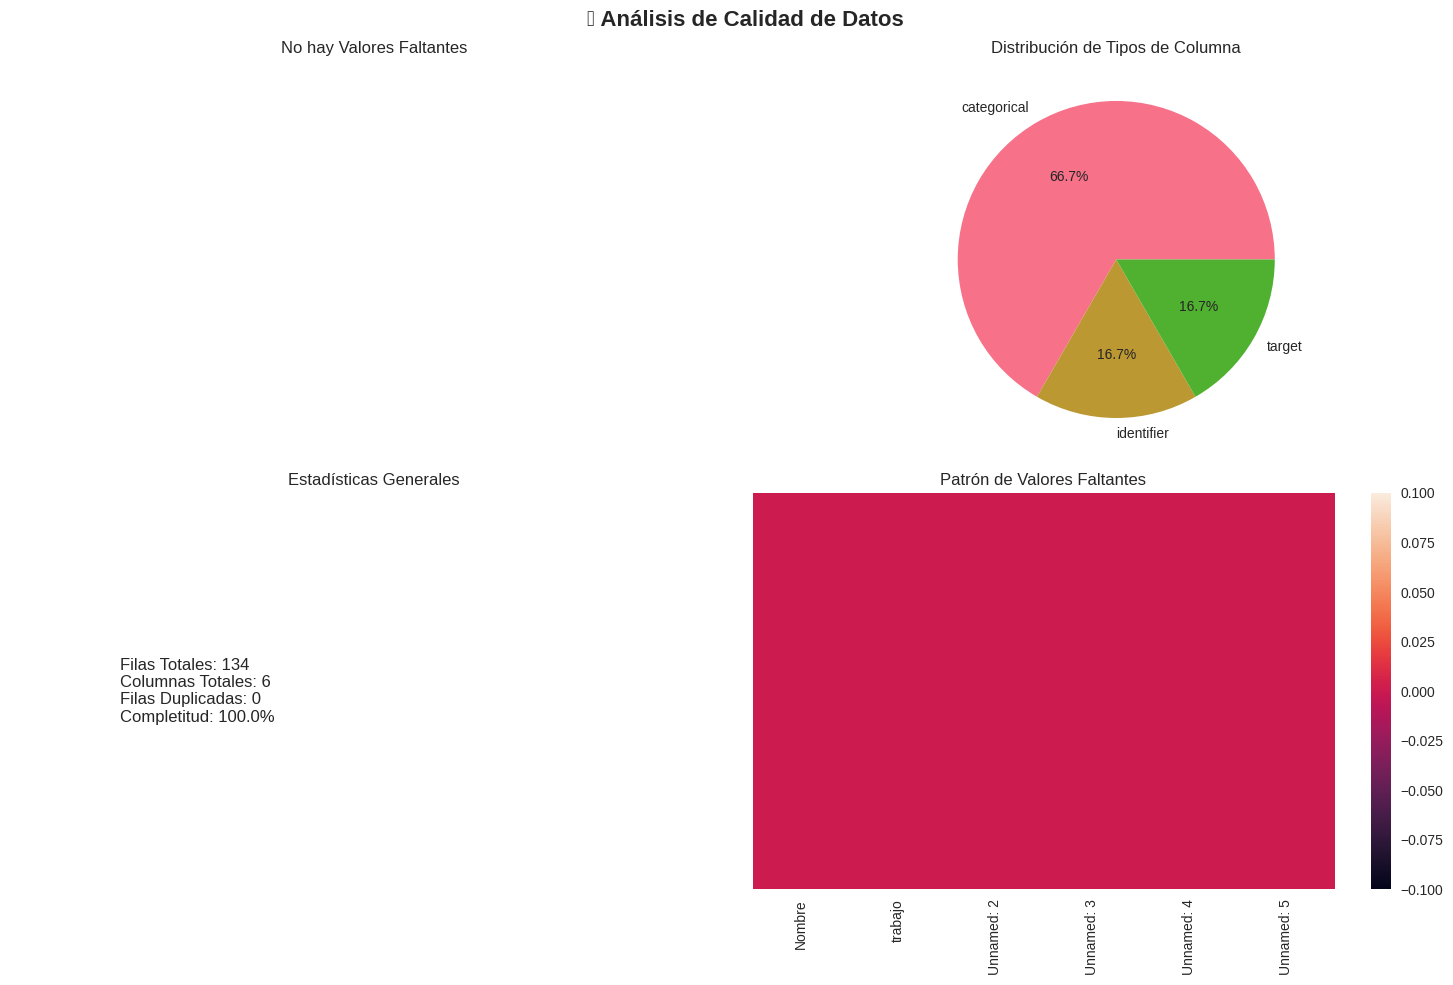

🔧 Iniciando preprocesamiento inteligente...
✅ Preprocesamiento completado. Shape: (134, 7)
🤖 Generando embeddings usando BERT...


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Embeddings generados. Shape: (134, 768)
🎯 Realizando clustering no supervisado...
📊 Número óptimo de clusters estimado: 4
✅ Clustering completado con 4 clusters


📚 Realizando modelado de temas con 5 tópicos...


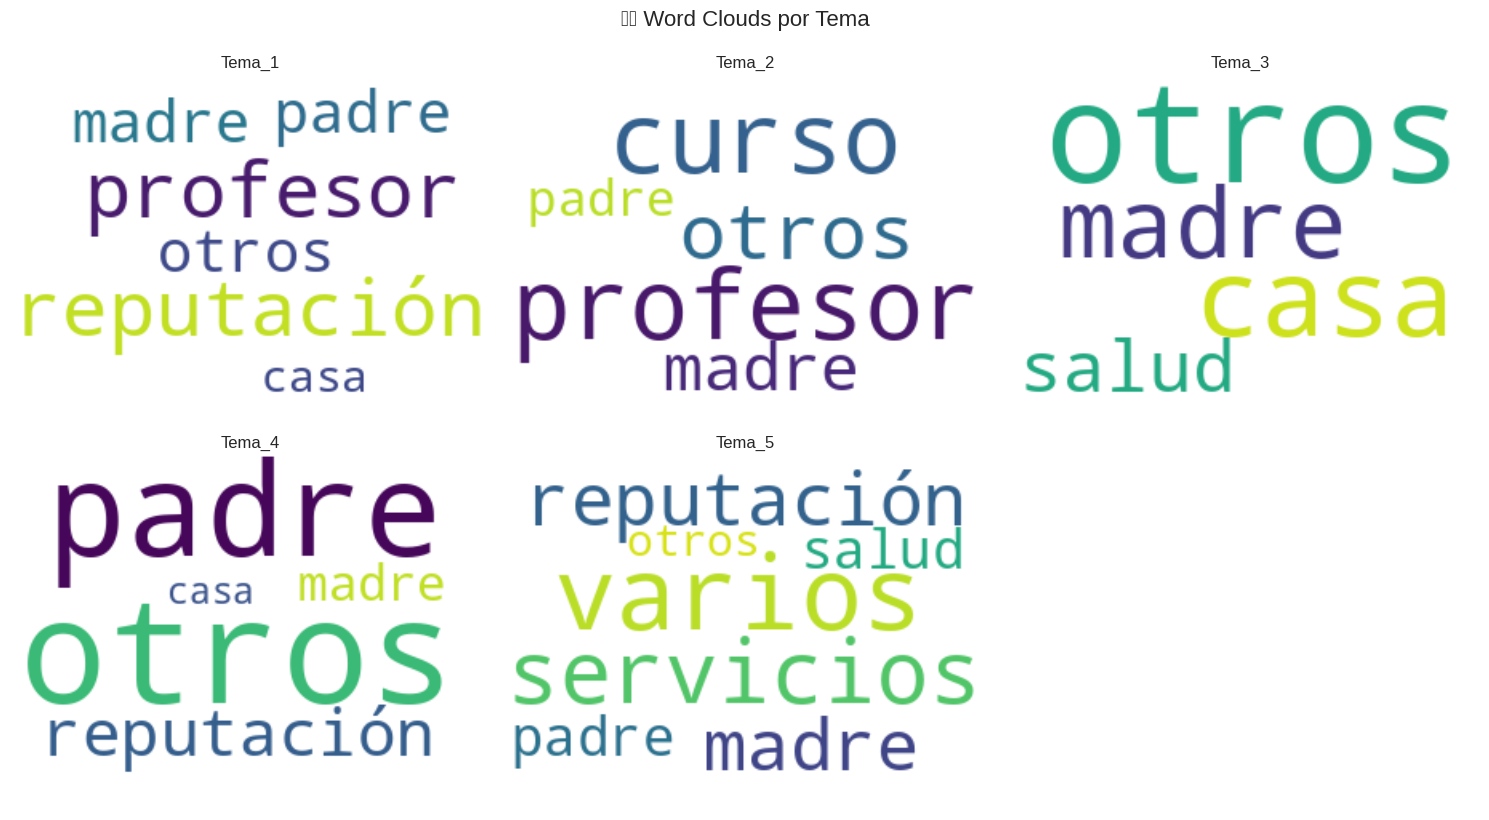

✅ Modelado de temas completado
🔍 Realizando análisis de similitud semántica...


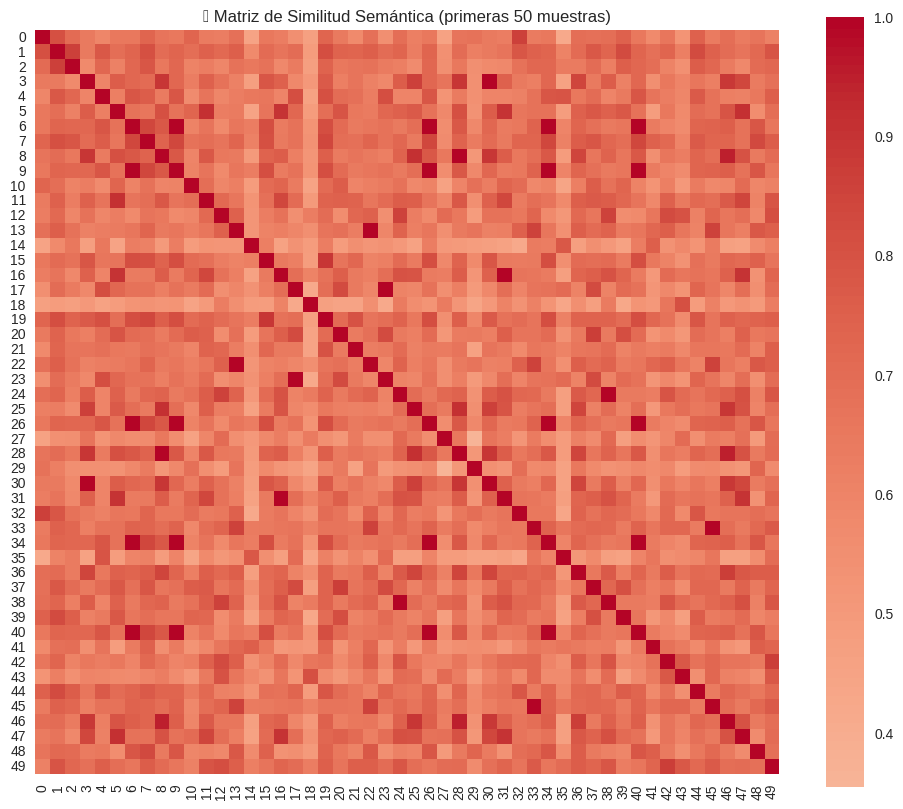

✅ Análisis completado. Encontrados 132 pares altamente similares
📐 Iniciando cálculo de distancia de Jaccard y generación de dendrograma...
📐 Calculando distancia de Jaccard...
✅ Distancia de Jaccard calculada. Shape: (134, 134)
🌳 Generando dendrograma basado en distancia de Jaccard...


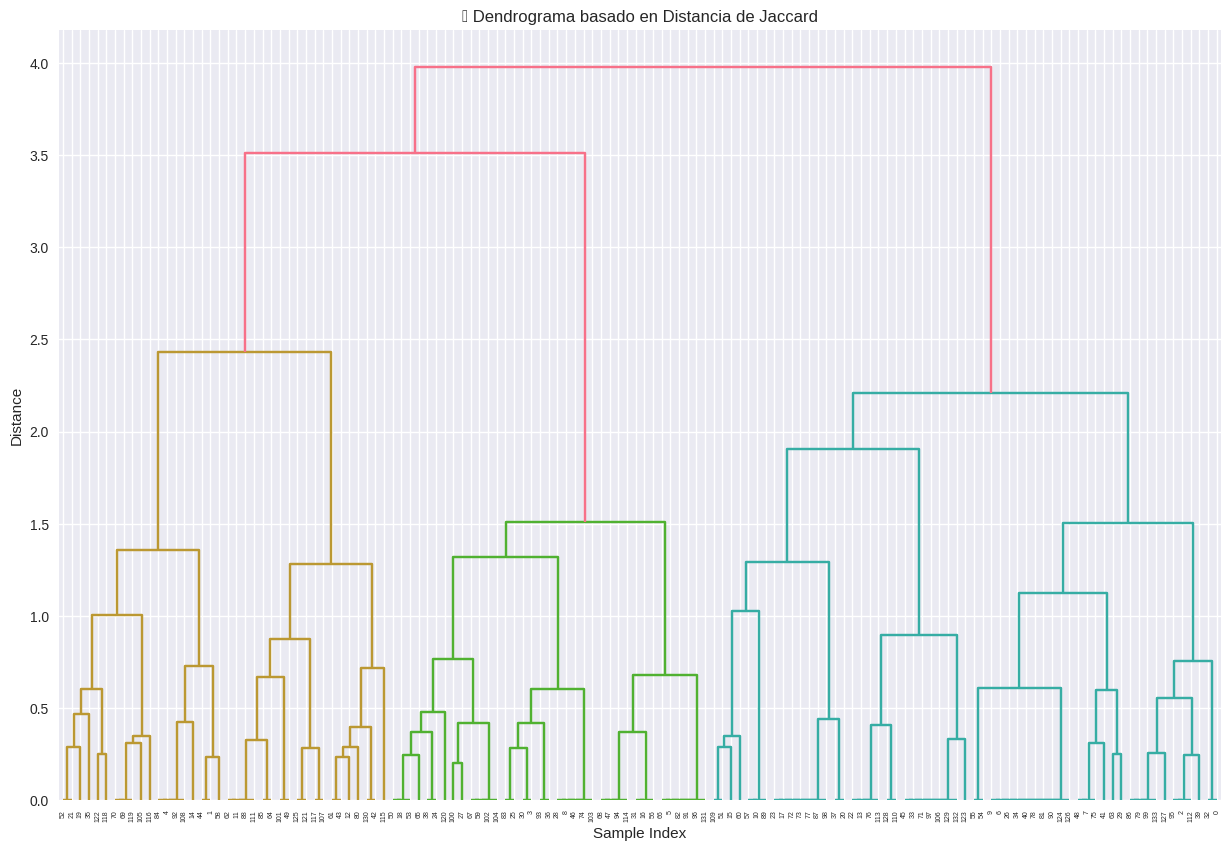

✅ Dendrograma generado.
✅ Cálculo de distancia de Jaccard y generación de dendrograma completados.
🕸️ Construyendo red semántica con threshold 0.7...


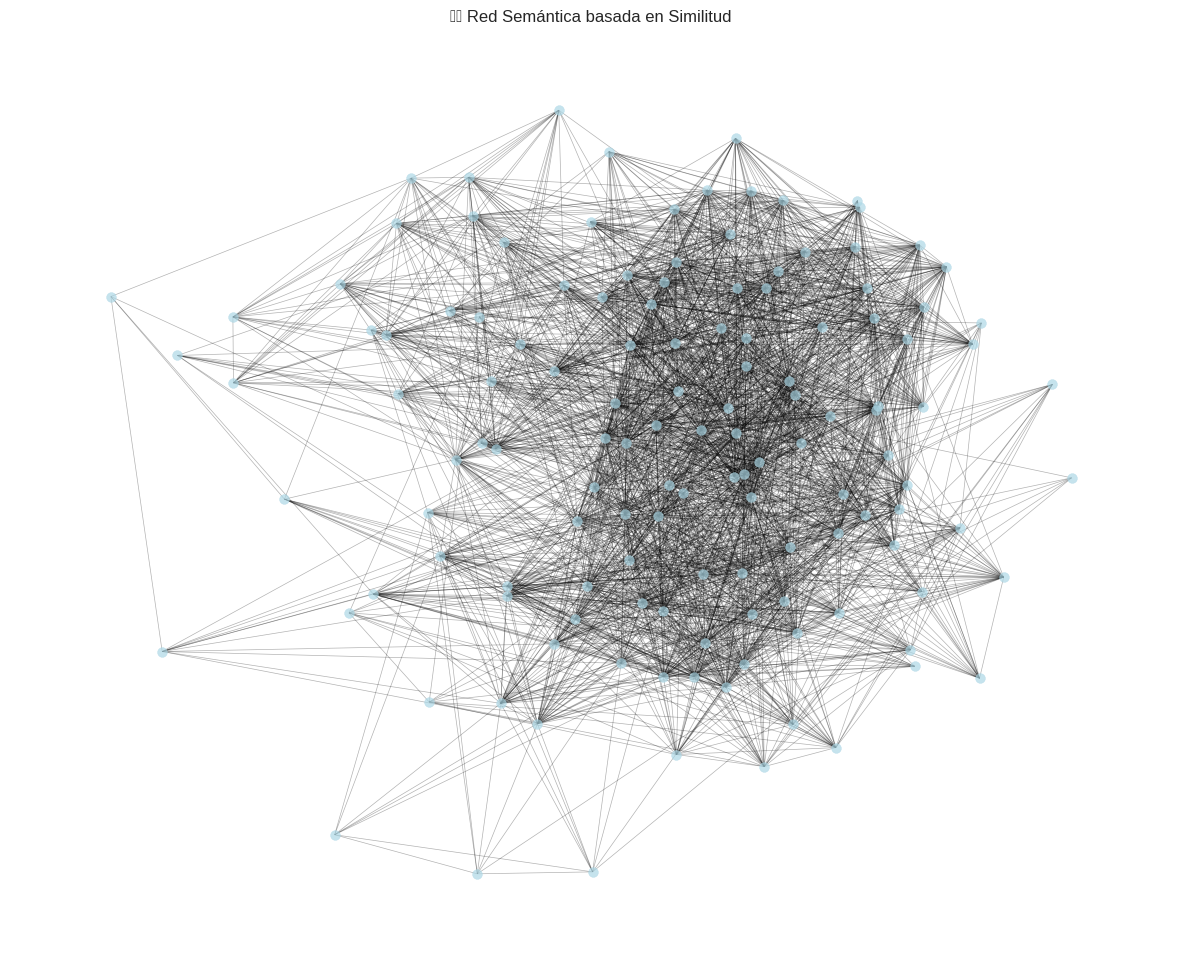

📊 Estadísticas de la red: {'nodes': 134, 'edges': 2753, 'density': 0.3089440017955336, 'components': 1}
🎯 Construyendo modelos predictivos...
   Entrenando Random Forest...
   Entrenando Logistic Regression...


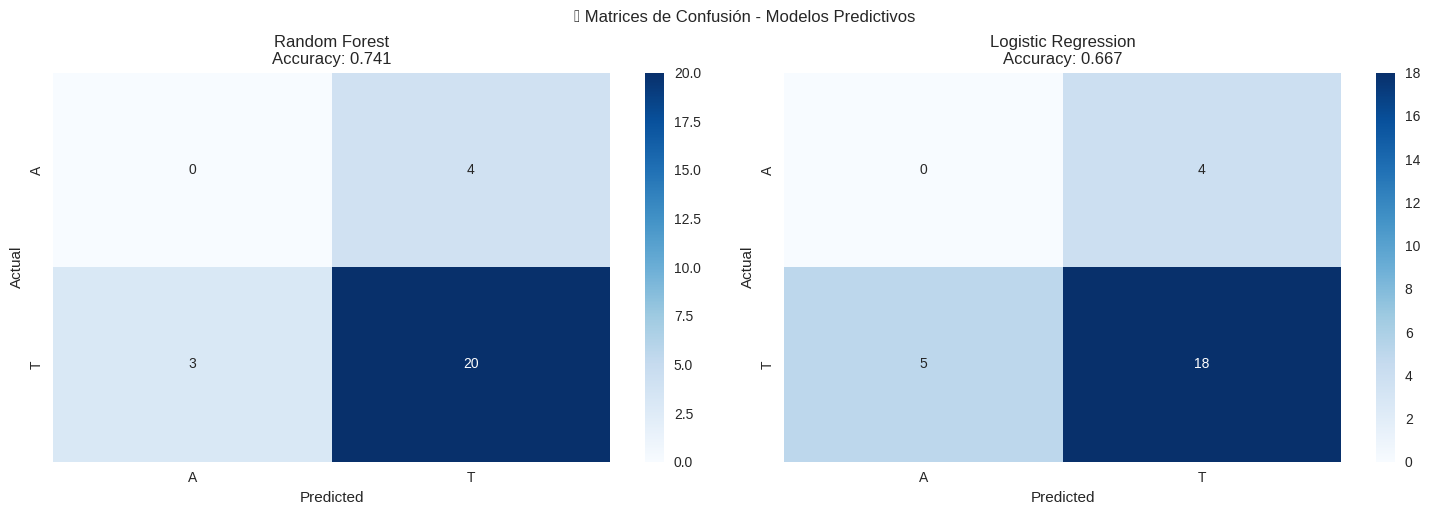

✅ Modelado predictivo completado
💡 Generando recomendaciones para muestra 0...
🔍 Muestra de referencia:
   en casa profesor curso madre...

💡 Recomendaciones:
   1. Similitud: 0.866
      profesor en casa curso madre...

   2. Similitud: 0.814
      en casa servicios varios curso madre...

   3. Similitud: 0.813
      en casa otros curso madre...

   4. Similitud: 0.813
      en casa otros curso madre...

   5. Similitud: 0.813
      en casa otros curso madre...

🚨 Realizando detección de anomalías...
🔍 Detectadas 14 anomalías (10.4% del dataset)


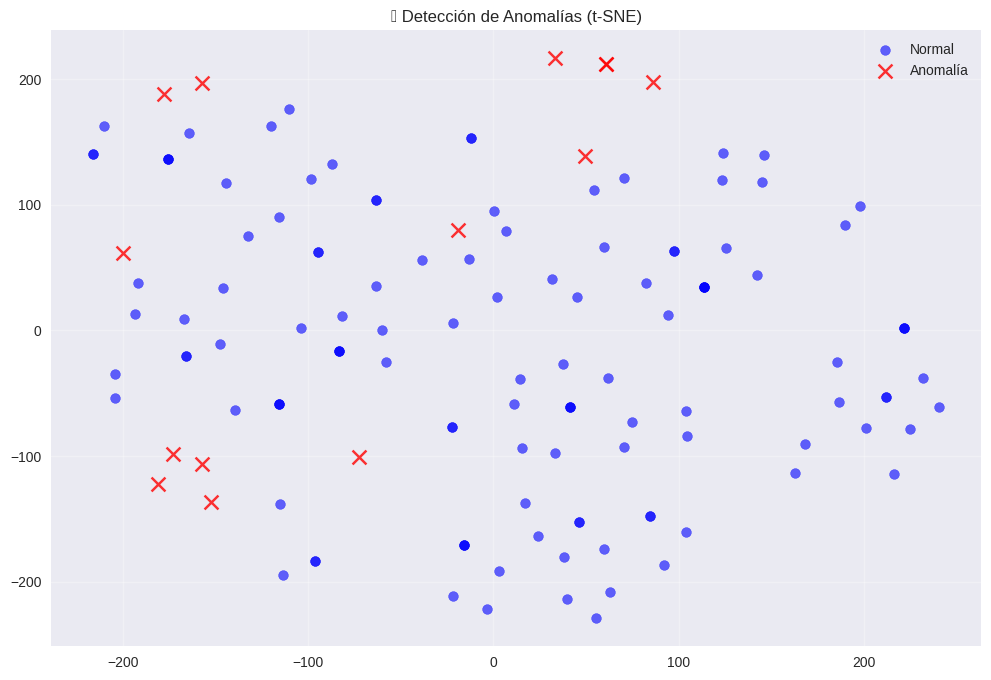


🔍 Ejemplos de anomalías detectadas:
   1. Índice 14: otros otros casa otros...
   2. Índice 27: salud servicios varios otros madre...
   3. Índice 29: profesor profesor casa madre...
   4. Índice 35: otros otros otros padre...
   5. Índice 39: en casa otros reputación madre...
📊 Generando visualizaciones avanzadas...


📅 No se detectaron patrones temporales claros
🔗 Analizando correlaciones categóricas...


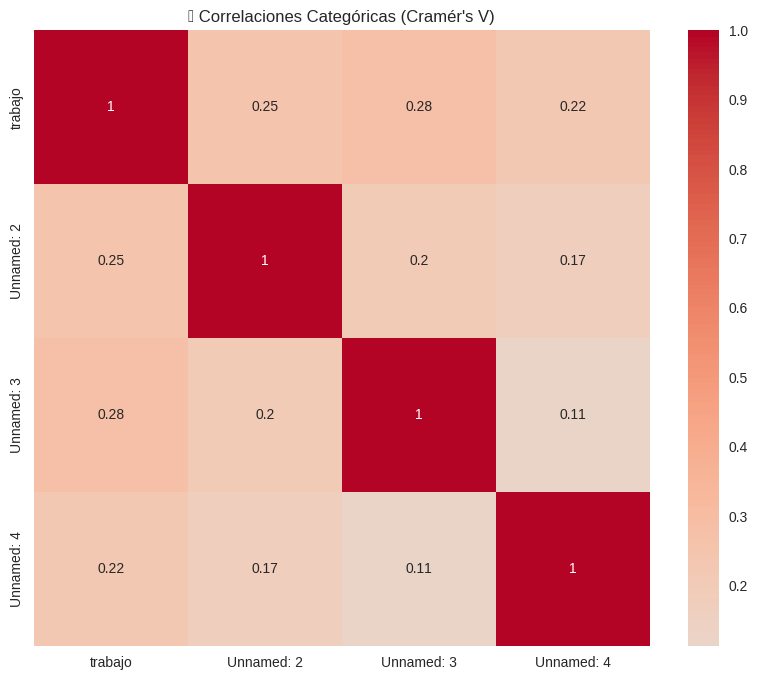

📋 Generando reporte completo...

📊 REPORTE COMPLETO DE ANÁLISIS NLP

📈 RESUMEN DEL DATASET:
   • Filas: 134
   • Columnas: 6
   • Completitud: 100.0%

🧠 INSIGHTS PRINCIPALES:
   • Clustering:
     - kmeans: 4 clusters
     - dbscan: 4 clusters
     - hierarchical: 4 clusters
   • Temas: 5
   • Mejor_Modelo:
     - nombre: Random Forest
     - accuracy: 0.741

💡 RECOMENDACIONES:
   1. Considerar aumentar el dataset si es posible para mejorar la robustez
   2. Explorar feature engineering adicional basado en los patrones encontrados
   3. Implementar validación cruzada para modelos más robustos
   4. Considerar técnicas de ensemble para mejorar el rendimiento predictivo


🎉 ¡ANÁLISIS COMPLETADO EXITOSAMENTE!


In [45]:
analyzer, report = run_complete_analysis(file_path='/content/drive/MyDrive/NLP/dataset1.csv')

## Summary:

### Data Analysis Key Findings

*   The `calculate_jaccard_similarity` method was successfully added to the `IntelligentNLPAnalyzer` class to compute the pairwise Jaccard distance between documents based on their token sets.
*   The `plot_dendrogram` method was implemented to perform hierarchical clustering on the Jaccard distance matrix and visualize the results as a dendrogram.
*   The `run_complete_analysis` function was modified to include the execution of both the `calculate_jaccard_similarity` and `plot_dendrogram` methods, integrating them into the overall NLP analysis pipeline.
*   Executing the modified code confirmed that the new methods run without errors and the dendrogram plot is generated and displayed as intended.

### Insights or Next Steps

*   The dendrogram visualization provides an alternative perspective on document relationships, complementing the clustering and semantic similarity analyses by showing hierarchical groupings based on shared vocabulary.
*   The Jaccard distance and dendrogram could be used to identify documents with very similar or identical text content, which might be useful for data cleaning or identifying duplicate entries.
